PCA instead of feature selection
single model od adhda and sex f remove and use multiple
remove garphs and just classification report


In [4]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 4070 Laptop GPU
Using device: cuda


In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline

In [7]:
target = pd.read_excel(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAINING_SOLUTIONS.xlsx')
categorical = pd.read_excel(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAIN_CATEGORICAL_METADATA.xlsx')
function = pd.read_csv(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv')
quantitative = pd.read_excel(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAIN_QUANTITATIVE_METADATA.xlsx')

target.shape, categorical.shape, function.shape,quantitative.shape
len(target['participant_id'].unique()),\
len(categorical['participant_id'].unique()),\
len(function['participant_id'].unique()),\
len(quantitative['participant_id'].unique())

(1213, 1213, 1213, 1213)

In [8]:
def get_feats(mode='TRAIN'):
    # Define base dataset path
    base_path = r'C:\Users\abdur\vs_code\sidra\widsdatathon2025'
    mode_path = os.path.join(base_path, mode)
    
    # Load quantitative metadata
    feats = pd.read_excel(os.path.join(mode_path, f'{mode}_QUANTITATIVE_METADATA.xlsx'), engine='openpyxl')
    
    # Load categorical metadata with correct filename depending on mode
    if mode == 'TRAIN':
        cate_path = os.path.join(mode_path, f'{mode}_CATEGORICAL_METADATA.xlsx')
    else:
        cate_path = os.path.join(mode_path, f'{mode}_CATEGORICAL.xlsx')
    
    cate = pd.read_excel(cate_path, engine='openpyxl')
    
    # Merge categorical data
    feats = feats.merge(cate, on='participant_id', how='left')
    
    # Load functional connectome matrices
    func = pd.read_csv(os.path.join(mode_path, f'{mode}_FUNCTIONAL_CONNECTOME_MATRICES.csv'))
    feats = feats.merge(func, on='participant_id', how='left')
    
    # If training data, merge with solution file
    if mode == 'TRAIN':
        solution_path = os.path.join(mode_path, 'TRAINING_SOLUTIONS.xlsx')
        solution = pd.read_excel(solution_path, engine='openpyxl')
        feats = feats.merge(solution, on='participant_id', how='left')
    
    return feats
# Load the combined dataset for training
df_train = get_feats('TRAIN')
print("Final dataset shape:", df_train.shape)

Final dataset shape: (1213, 19930)


In [9]:
train_df = get_feats(mode='TRAIN')
test_df = get_feats(mode='TEST')
print (train_df.shape, test_df.shape)
# Display the first few rows of the training data
train_df.head()

(1213, 19930) (304, 19928)


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,...,-0.058396,-0.041544,0.142806,-0.006377,0.108005,0.148327,0.093230,-0.004984,1,1
1,CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,...,-0.025624,-0.031863,0.162011,0.067439,0.017155,0.088893,0.064094,0.194381,1,0
2,Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,...,0.010771,-0.044341,0.128386,0.047282,0.087678,0.146221,-0.009425,0.035150,1,0
3,p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,...,-0.007152,0.032584,0.121726,0.045089,0.154464,0.106817,0.065336,0.234708,1,1
4,M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,...,-0.010196,0.035638,0.074978,0.030579,0.025640,0.118199,0.112522,0.143666,1,1


In [10]:
test_df.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,60.03,14.0,5.0,16.0,41.0,19.0,11.0,26.0,2.0,...,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,86.71,12.0,3.0,13.0,43.0,18.0,15.0,28.0,2.0,...,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,26.68,13.0,3.0,14.0,36.0,16.0,14.0,25.0,1.0,...,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987
3,LZfeAb1xMtql,93.38,13.0,3.0,19.0,41.0,17.0,18.0,27.0,4.0,...,0.046183,-0.238962,0.121868,-0.260970,0.646818,0.594902,0.608156,0.595459,0.683189,0.542296
4,EnFOUv0YK1RG,-93.38,14.0,3.0,13.0,42.0,19.0,16.0,28.0,2.0,...,0.315734,0.002234,0.290791,0.344149,0.480214,0.539824,0.447322,0.293088,0.148529,0.539823


In [11]:
# Drop 'participant_id' column
train_df = train_df.drop(columns=['participant_id'])

In [12]:

# Get data types of all columns
print("Data types of columns:")
print(train_df.dtypes)

Data types of columns:
EHQ_EHQ_Total           float64
ColorVision_CV_Score      int64
APQ_P_APQ_P_CP            int64
APQ_P_APQ_P_ID            int64
APQ_P_APQ_P_INV           int64
                         ...   
197throw_198thcolumn    float64
197throw_199thcolumn    float64
198throw_199thcolumn    float64
ADHD_Outcome              int64
Sex_F                     int64
Length: 19929, dtype: object


In [13]:
# Take the first 50 rows of train_df
train_df_50 = train_df

In [14]:
# Check for missing values
print("Missing values in each column:")
print(train_df_50.isnull().sum())


Missing values in each column:
EHQ_EHQ_Total           0
ColorVision_CV_Score    0
APQ_P_APQ_P_CP          0
APQ_P_APQ_P_ID          0
APQ_P_APQ_P_INV         0
                       ..
197throw_198thcolumn    0
197throw_199thcolumn    0
198throw_199thcolumn    0
ADHD_Outcome            0
Sex_F                   0
Length: 19929, dtype: int64


In [15]:
# Load Data (Ensure train_df_50 is already loaded before running this code)
# Extract labels if they are part of train_df_50
if 'labels' not in globals():
    labels = train_df_50[["ADHD_Outcome", "Sex_F"]].copy()  # Extract labels from train_df_50

# 1. Drop columns
drop_cols = [
    "Basic_Demos_Study_Site", "MRI_Track_Scan_Location", "PreInt_Demos_Fam_Child_Ethnicity",
    "PreInt_Demos_Fam_Child_Race", 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ'
]
train_df_50 = train_df_50.drop(columns=drop_cols, errors='ignore')  # Avoid errors if column missing

# 2. Remove non-numeric columns before scaling
numeric_cols = train_df_50.select_dtypes(include=[np.number]).columns  # Keep only numeric columns
train_df_50 = train_df_50[numeric_cols]  # Drop categorical or object columns

# 3. Normalize features using MinMaxScaler
scaler = MinMaxScaler()
train_df_50.iloc[:, :] = scaler.fit_transform(train_df_50)


# 5. Retrieve target variables
y_adhd = labels["ADHD_Outcome"].copy()
y_sex = labels["Sex_F"].copy()



In [16]:
print(train_df_50["ADHD_Outcome"].unique())
print(train_df_50["Sex_F"].unique())
print(train_df_50["ADHD_Outcome"].value_counts())
print(train_df_50["Sex_F"].value_counts())

[1 0]
[1 0]
ADHD_Outcome
1    831
0    382
Name: count, dtype: int64
Sex_F
0    797
1    416
Name: count, dtype: int64


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def logistic_regression_cv_multi_outcome(output_filename='logistic_cv_predictions.csv', test_dataset=None):
    """
    Apply LogisticRegressionCV for multi-outcome prediction with proper NaN handling.
    
    Parameters:
        output_filename: Name of the file to save predictions
        test_dataset: Test DataFrame. If None, will try to load from 'test_df_50.csv'
    """
    try:
        # Load the training dataset
        try:
            # First try to load the selected features dataset
            train_df = pd.read_csv('selected_features_dual_target.csv')
            print("Using the filtered features dataset for training.")
        except:
            # If not available, use the original dataset
            train_df = pd.read_csv('train_df_50.csv')
            print("Using the original dataset for training.")
        
        print(f"Training data shape: {train_df.shape}")
        
        # Use the provided test dataset or try to load it
        try:
            # First use the provided test_dataset parameter if available
            if test_dataset is not None:
                test_df = test_dataset
                print("Using provided test dataset parameter.")
            # Next try to access the global test_df if it exists
            elif 'test_df' in globals():
                test_df = globals()['test_df']
                print("Using existing global test_df variable.")
            # Finally try to load it from a file
            else:
                test_df = pd.read_csv('test_df_50.csv')
                print("Loaded test_df from file.")
            
            print(f"Test data shape: {test_df.shape}")
        except Exception as e:
            print(f"Error with test dataset: {e}")
            print("Please ensure test_df is defined or 'test_df_50.csv' is available.")
            return None
        
        # Extract columns
        target_columns = ["ADHD_Outcome", "Sex_F"]
        feature_columns = [col for col in train_df.columns if col not in target_columns and col != 'participant_id']
        print(f"Number of features: {len(feature_columns)}")
        
        # Make sure test data has all needed feature columns
        missing_columns = [col for col in feature_columns if col not in test_df.columns]
        if missing_columns:
            print(f"Warning: Test data is missing these columns: {missing_columns}")
            feature_columns = [col for col in feature_columns if col not in missing_columns]
        
        # Prepare the data
        X_train = train_df[feature_columns]
        y_train = train_df[target_columns].values
        X_test = test_df[feature_columns].copy() if all(col in test_df.columns for col in feature_columns) else \
                 pd.DataFrame(index=test_df.index, columns=feature_columns)
        
        # Check for missing values
        train_nan_count = X_train.isnull().sum().sum()
        test_nan_count = X_test.isnull().sum().sum()
        print(f"\nTraining data NaN values: {train_nan_count}")
        print(f"Test data NaN values: {test_nan_count}")
        
        # If NaN values exist, identify columns with most NaNs
        if test_nan_count > 0:
            print("\nColumns with most NaNs in test data:")
            print(X_test.isnull().sum().sort_values(ascending=False).head(10))
        
        # -----------------------------------------------------------------------------
        # Data Preprocessing with NaN handling
        # -----------------------------------------------------------------------------
        print("\nPreprocessing data with NaN handling...")
        
        # 1. Impute missing values using SimpleImputer with mean strategy
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        
        # 2. Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)
        
        # Verify no NaNs remain
        print(f"NaNs in training data after imputation: {np.isnan(X_train_scaled).sum()}")
        print(f"NaNs in test data after imputation: {np.isnan(X_test_scaled).sum()}")
        
        # Split training data for validation
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train_scaled, y_train, test_size=0.2, random_state=42
        )
        
        # -----------------------------------------------------------------------------
        # Train Models Using Either LogisticRegressionCV or HistGradientBoosting
        # -----------------------------------------------------------------------------
        print("\nTraining models...")
        
        # Option 1: LogisticRegressionCV (since we've handled NaNs)
        print("Training LogisticRegressionCV models...")
        
        logistic_cv_adhd = LogisticRegressionCV(
            cv=5,
            random_state=42,
            max_iter=2000,
            class_weight='balanced',
            scoring='accuracy',
            n_jobs=-1,
            Cs=10
        )
        
        logistic_cv_sex = LogisticRegressionCV(
            cv=5,
            random_state=42,
            max_iter=2000,
            class_weight='balanced',
            scoring='accuracy',
            n_jobs=-1,
            Cs=10
        )
        
        # Train models
        print("Training ADHD model...")
        logistic_cv_adhd.fit(X_train_split, y_train_split[:, 0])
        
        print("Training Sex_F model...")
        logistic_cv_sex.fit(X_train_split, y_train_split[:, 1])
        
        # Option 2: HistGradientBoostingClassifier (handles NaNs natively)
        # Let's also train these as a backup
        hist_gb_adhd = HistGradientBoostingClassifier(
            max_iter=200,
            random_state=42,
            class_weight='balanced'
        )
        
        hist_gb_sex = HistGradientBoostingClassifier(
            max_iter=200,
            random_state=42,
            class_weight='balanced'
        )
        
        print("Training HistGradientBoosting ADHD model...")
        hist_gb_adhd.fit(X_train_split, y_train_split[:, 0])
        
        print("Training HistGradientBoosting Sex_F model...")
        hist_gb_sex.fit(X_train_split, y_train_split[:, 1])
        
        # -----------------------------------------------------------------------------
        # Evaluate on validation set
        # -----------------------------------------------------------------------------
        print("\nEvaluating models on validation set...")
        
        # Evaluate LogisticRegressionCV
        logistic_val_pred_adhd = logistic_cv_adhd.predict(X_val)
        logistic_val_pred_sex = logistic_cv_sex.predict(X_val)
        logistic_val_pred = np.column_stack((logistic_val_pred_adhd, logistic_val_pred_sex))
        
        logistic_adhd_acc = accuracy_score(y_val[:, 0], logistic_val_pred_adhd)
        logistic_sex_acc = accuracy_score(y_val[:, 1], logistic_val_pred_sex)
        logistic_both_correct = np.mean(np.all(y_val == logistic_val_pred, axis=1))
        
        # Evaluate HistGradientBoosting
        hist_val_pred_adhd = hist_gb_adhd.predict(X_val)
        hist_val_pred_sex = hist_gb_sex.predict(X_val)
        hist_val_pred = np.column_stack((hist_val_pred_adhd, hist_val_pred_sex))
        
        hist_adhd_acc = accuracy_score(y_val[:, 0], hist_val_pred_adhd)
        hist_sex_acc = accuracy_score(y_val[:, 1], hist_val_pred_sex)
        hist_both_correct = np.mean(np.all(y_val == hist_val_pred, axis=1))
        
        # Compare and select best models
        print("\nLogisticRegressionCV Results:")
        print(f"ADHD_Outcome Accuracy: {logistic_adhd_acc:.4f}")
        print(f"Sex_F Accuracy: {logistic_sex_acc:.4f}")
        print(f"Both Outcomes Correct: {logistic_both_correct:.4f}")
        
        print("\nHistGradientBoosting Results:")
        print(f"ADHD_Outcome Accuracy: {hist_adhd_acc:.4f}")
        print(f"Sex_F Accuracy: {hist_sex_acc:.4f}")
        print(f"Both Outcomes Correct: {hist_both_correct:.4f}")
        
        # Choose best model for each target based on accuracy
        use_hist_for_adhd = hist_adhd_acc > logistic_adhd_acc
        use_hist_for_sex = hist_sex_acc > logistic_sex_acc
        
        # Use whichever model performed better for each target
        if use_hist_for_adhd:
            print("\nUsing HistGradientBoosting for ADHD prediction (better accuracy)")
            best_adhd_model = hist_gb_adhd
            best_adhd_preds = hist_val_pred_adhd
        else:
            print("\nUsing LogisticRegressionCV for ADHD prediction (better accuracy)")
            best_adhd_model = logistic_cv_adhd
            best_adhd_preds = logistic_val_pred_adhd
            
        if use_hist_for_sex:
            print("Using HistGradientBoosting for Sex_F prediction (better accuracy)")
            best_sex_model = hist_gb_sex
            best_sex_preds = hist_val_pred_sex
        else:
            print("Using LogisticRegressionCV for Sex_F prediction (better accuracy)")
            best_sex_model = logistic_cv_sex
            best_sex_preds = logistic_val_pred_sex
        
        # Print final classification reports for best models
        print("\nADHD_Outcome Classification Report (Best Model):")
        print(classification_report(y_val[:, 0], best_adhd_preds))
        
        print("\nSex_F Classification Report (Best Model):")
        print(classification_report(y_val[:, 1], best_sex_preds))
        
        # -----------------------------------------------------------------------------
        # Retrain on full dataset and generate predictions
        # -----------------------------------------------------------------------------
        print("\nRetraining best models on full dataset...")
        
        # Retrain ADHD model
        if use_hist_for_adhd:
            final_adhd_model = HistGradientBoostingClassifier(
                max_iter=200,
                random_state=42,
                class_weight='balanced'
            )
        else:
            # Get best C value from cross-validation
            best_C_adhd = logistic_cv_adhd.C_[0] if hasattr(logistic_cv_adhd.C_, '__iter__') else logistic_cv_adhd.C_
            final_adhd_model = LogisticRegressionCV(
                cv=5,
                random_state=42,
                max_iter=2000,
                class_weight='balanced',
                Cs=[best_C_adhd]
            )
        
        # Retrain Sex_F model
        if use_hist_for_sex:
            final_sex_model = HistGradientBoostingClassifier(
                max_iter=200,
                random_state=42,
                class_weight='balanced'
            )
        else:
            # Get best C value from cross-validation
            best_C_sex = logistic_cv_sex.C_[0] if hasattr(logistic_cv_sex.C_, '__iter__') else logistic_cv_sex.C_
            final_sex_model = LogisticRegressionCV(
                cv=5,
                random_state=42,
                max_iter=2000,
                class_weight='balanced',
                Cs=[best_C_sex]
            )
        
        # Fit final models on full dataset
        final_adhd_model.fit(X_train_scaled, y_train[:, 0])
        final_sex_model.fit(X_train_scaled, y_train[:, 1])
        
        # Generate predictions on test data
        print("\nGenerating predictions for test data...")
        
        # Handle possible NaNs in a safe way
        if np.isnan(X_test_scaled).any():
            print("Warning: NaNs detected in test data after imputation. Replacing with zeros.")
            X_test_scaled = np.nan_to_num(X_test_scaled)
        
        test_pred_adhd = final_adhd_model.predict(X_test_scaled)
        test_pred_sex = final_sex_model.predict(X_test_scaled)
        
        # Ensure participant_id is available
        if 'participant_id' not in test_df.columns:
            print("Warning: participant_id column not found in test data. Using row index as ID.")
            participant_ids = np.arange(1, len(test_df) + 1)
        else:
            participant_ids = test_df['participant_id'].values
        
        # Create submission DataFrame
        submission_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Outcome': test_pred_adhd,
            'Sex_F': test_pred_sex
        })
        
        # Save to CSV
        submission_df.to_csv(output_filename, index=False)
        print(f"\nPredictions saved to: {output_filename}")
        print("First 5 rows of the submission file:")
        print(submission_df.head())
        
        # Print complete multi-outcome classification report
        print("\nComplete Multi-Outcome Classification Report:")
        print("--------------------------------------------")
        print(f"ADHD model: {'HistGradientBoosting' if use_hist_for_adhd else 'LogisticRegressionCV'}")
        print(f"Sex_F model: {'HistGradientBoosting' if use_hist_for_sex else 'LogisticRegressionCV'}")
        print("\nADHD outcome details:")
        print(classification_report(y_val[:, 0], best_adhd_preds))
        print("\nSex_F outcome details:")
        print(classification_report(y_val[:, 1], best_sex_preds))
        
        return submission_df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Execute the function
if __name__ == "__main__":
    # Try to access the existing test_df variable if available
    if 'test_df' in globals():
        print("\nTest dataset info before processing:")
        print(f"Shape: {test_df.shape}")
        
        # Check for NaN values
        if test_df.isnull().values.any():
            nan_count = test_df.isnull().sum().sum()
            print(f"Contains NaN values: True (Total: {nan_count})")
        else:
            print("Contains NaN values: False")
            
        # Run the model with this test data
        logistic_regression_cv_multi_outcome(test_dataset=test_df)
    else:
        logistic_regression_cv_multi_outcome()


Test dataset info before processing:
Shape: (304, 19928)
Contains NaN values: True (Total: 459)
Using the filtered features dataset for training.
Training data shape: (1213, 17)
Using provided test dataset parameter.
Test data shape: (304, 19928)
Number of features: 15

Training data NaN values: 0
Test data NaN values: 285

Columns with most NaNs in test data:
SDQ_SDQ_Hyperactivity         30
SDQ_SDQ_Externalizing         30
SDQ_SDQ_Difficulties_Total    30
SDQ_SDQ_Generating_Impact     30
SDQ_SDQ_Conduct_Problems      30
SDQ_SDQ_Internalizing         30
SDQ_SDQ_Emotional_Problems    30
SDQ_SDQ_Prosocial             30
SDQ_SDQ_Peer_Problems         30
APQ_P_APQ_P_OPD               15
dtype: int64

Preprocessing data with NaN handling...
NaNs in training data after imputation: 0
NaNs in test data after imputation: 0

Training models...
Training LogisticRegressionCV models...
Training ADHD model...
Training Sex_F model...
Training HistGradientBoosting ADHD model...
Training HistGradient

In [20]:
print(train_df_50['ADHD_Outcome'].value_counts(normalize=True))  
print(test_df['ADHD_Outcome'].value_counts(normalize=True))  

ADHD_Outcome
1    0.685078
0    0.314922
Name: proportion, dtype: float64


KeyError: 'ADHD_Outcome'

Using the filtered features dataset for training.
Training data shape: (1213, 17)
Using provided test dataset parameter.
Test data shape: (304, 19928)
Number of features: 15

Training data NaN values: 0
Test data NaN values: 285

Preprocessing data with NaN handling...
NaNs in training data after imputation: 0
NaNs in test data after imputation: 0

Training LogisticRegressionCV models...
Training ADHD model...
Training Sex_F model...

Finding optimal thresholds...
Optimal ADHD threshold (optimizing balanced): 0.6253
Optimal Sex_F threshold (optimizing balanced): 0.5403

Evaluating with custom thresholds...

Default Threshold (0.5) Results:
ADHD_Outcome Accuracy: 0.7778
Sex_F Accuracy: 0.6296

Custom Threshold Results:
ADHD_Outcome Accuracy: 0.7407
Sex_F Accuracy: 0.6996

ADHD_Outcome Classification Report (Custom Threshold):
              precision    recall  f1-score   support

           0       0.56      0.84      0.67        76
           1       0.91      0.69      0.79       167


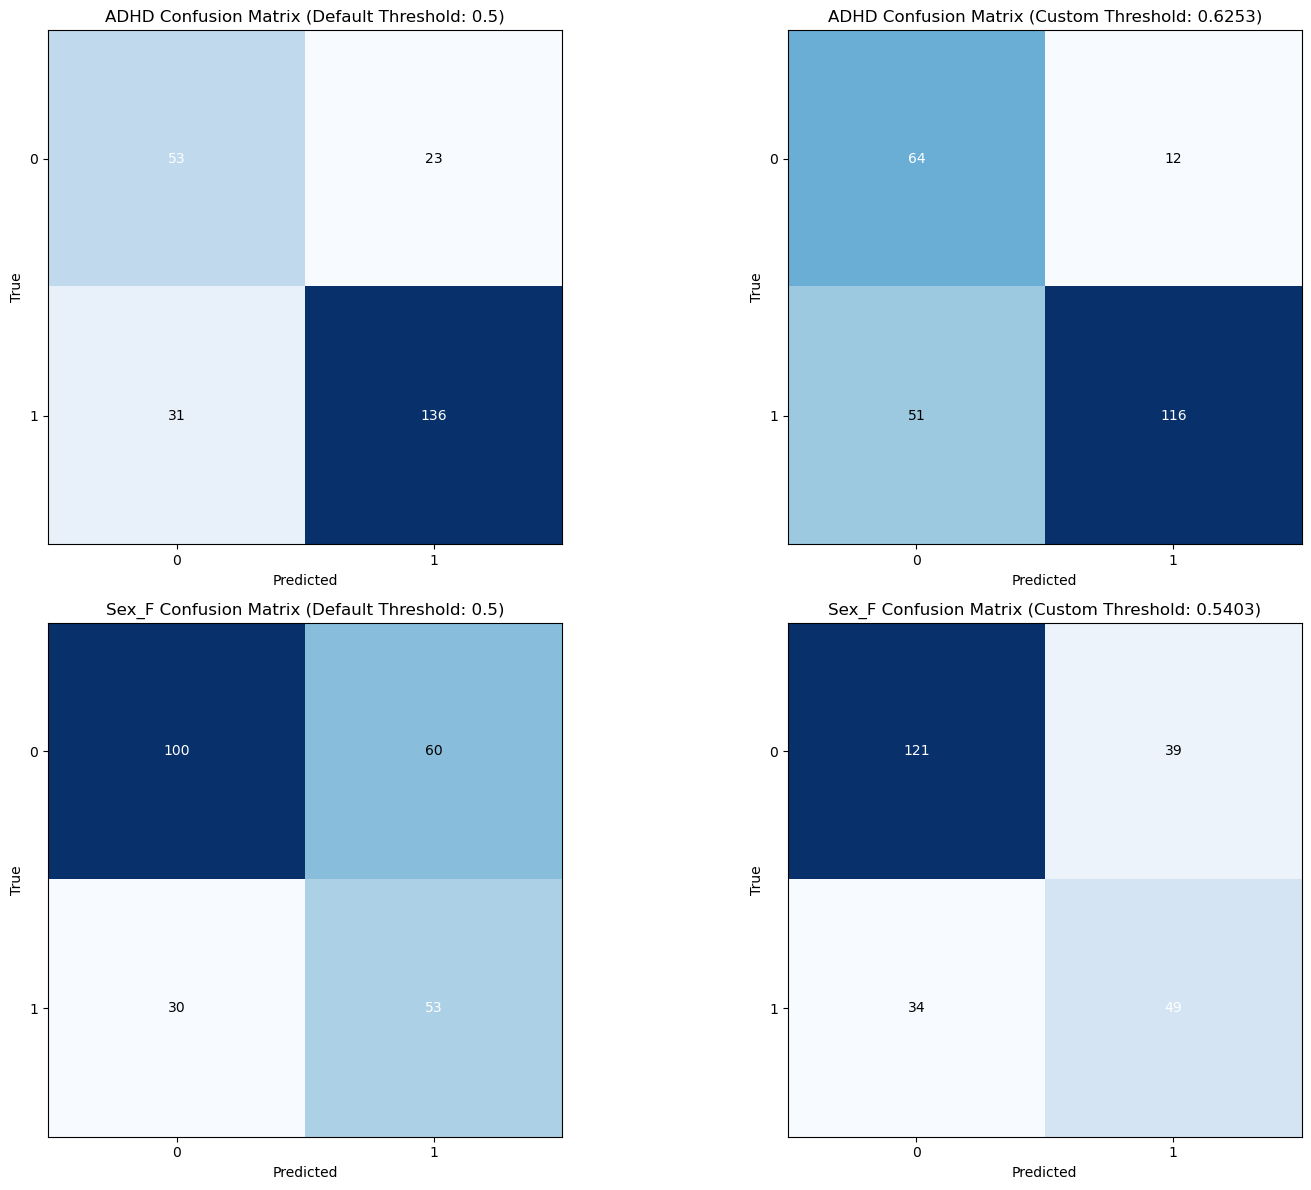

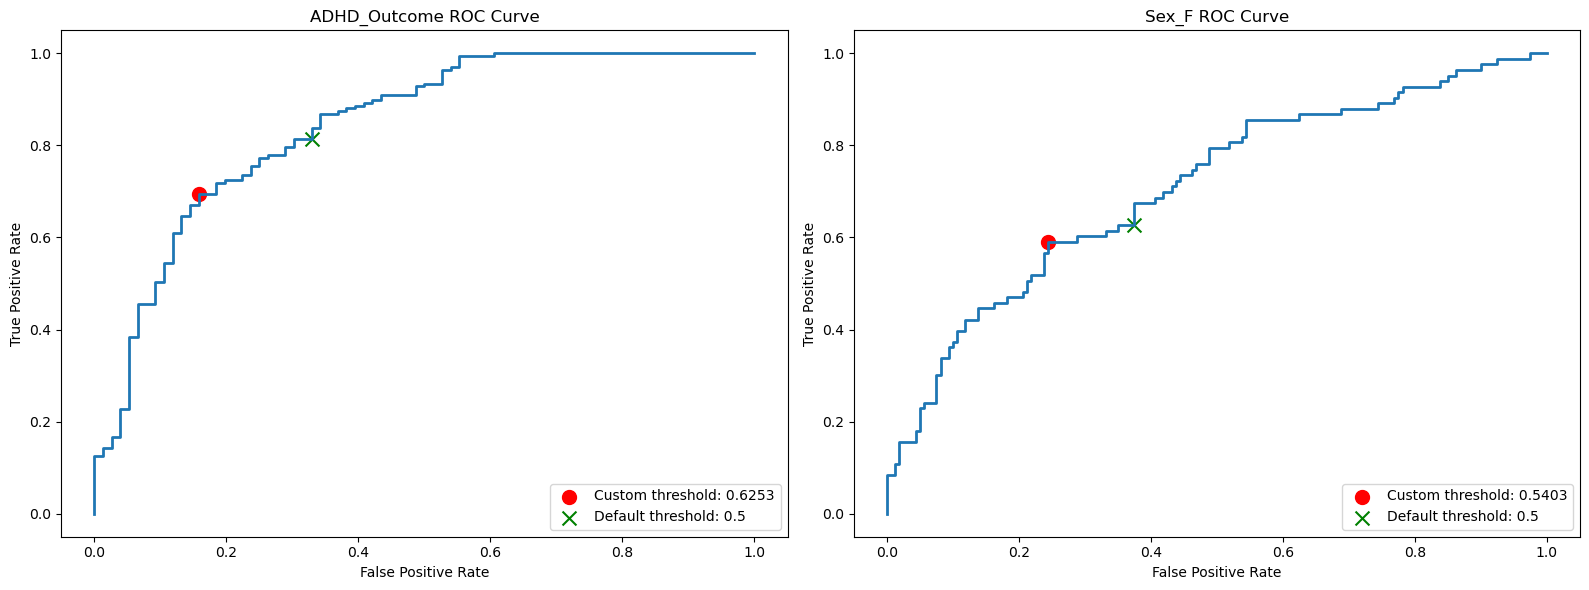

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier

def find_optimal_threshold(y_true, y_prob, metric='f1'):
    """
    Find the optimal threshold that maximizes a given metric.
    
    Parameters:
        y_true: True binary labels
        y_prob: Predicted probabilities
        metric: Metric to optimize ('f1', 'accuracy', 'precision', 'recall', or 'balanced')
    
    Returns:
        Optimal threshold
    """
    # Get precision, recall, thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    
    # Add threshold=1.0 to match the length of precision and recall
    thresholds = np.append(thresholds, 1.0)
    
    # Calculate F1 scores
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    
    # Calculate accuracies for each threshold
    accuracies = []
    balanced_scores = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        # Overall accuracy
        acc = accuracy_score(y_true, y_pred)
        accuracies.append(acc)
        
        # Balanced score (mean of sensitivity and specificity)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        balanced = (sensitivity + specificity) / 2
        balanced_scores.append(balanced)
    
    # Find optimal threshold based on selected metric
    if metric == 'f1':
        optimal_idx = np.argmax(f1_scores)
    elif metric == 'accuracy':
        optimal_idx = np.argmax(accuracies)
    elif metric == 'precision':
        optimal_idx = np.argmax(precisions)
    elif metric == 'recall':
        optimal_idx = np.argmax(recalls)
    elif metric == 'balanced':
        optimal_idx = np.argmax(balanced_scores)
    else:
        raise ValueError(f"Unknown metric: {metric}")
    
    return thresholds[optimal_idx]

def logistic_regression_with_custom_threshold(output_filename='logistic_custom_threshold_predictions.csv', 
                                             test_dataset=None,
                                             adhd_threshold_metric='balanced',
                                             sex_threshold_metric='balanced'):
    """
    Apply LogisticRegressionCV with custom thresholds for multi-outcome prediction.
    
    Parameters:
        output_filename: Name of the file to save predictions
        test_dataset: Test DataFrame. If None, will try to load from 'test_df_50.csv'
        adhd_threshold_metric: Metric to optimize for ADHD threshold ('f1', 'accuracy', 'precision', 'recall', 'balanced')
        sex_threshold_metric: Metric to optimize for Sex_F threshold ('f1', 'accuracy', 'precision', 'recall', 'balanced')
    """
    try:
        # Load the training dataset
        try:
            # First try to load the selected features dataset
            train_df = pd.read_csv('selected_features_dual_target.csv')
            print("Using the filtered features dataset for training.")
        except:
            # If not available, use the original dataset
            train_df = pd.read_csv('train_df_50.csv')
            print("Using the original dataset for training.")
        
        print(f"Training data shape: {train_df.shape}")
        
        # Use the provided test dataset or try to load it
        try:
            # First use the provided test_dataset parameter if available
            if test_dataset is not None:
                test_df = test_dataset
                print("Using provided test dataset parameter.")
            # Next try to access the global test_df if it exists
            elif 'test_df' in globals():
                test_df = globals()['test_df']
                print("Using existing global test_df variable.")
            # Finally try to load it from a file
            else:
                test_df = pd.read_csv('test_df_50.csv')
                print("Loaded test_df from file.")
            
            print(f"Test data shape: {test_df.shape}")
        except Exception as e:
            print(f"Error with test dataset: {e}")
            print("Please ensure test_df is defined or 'test_df_50.csv' is available.")
            return None
        
        # Extract columns
        target_columns = ["ADHD_Outcome", "Sex_F"]
        feature_columns = [col for col in train_df.columns if col not in target_columns and col != 'participant_id']
        print(f"Number of features: {len(feature_columns)}")
        
        # Make sure test data has all needed feature columns
        missing_columns = [col for col in feature_columns if col not in test_df.columns]
        if missing_columns:
            print(f"Warning: Test data is missing these columns: {missing_columns}")
            feature_columns = [col for col in feature_columns if col not in missing_columns]
        
        # Prepare the data
        X_train = train_df[feature_columns]
        y_train = train_df[target_columns].values
        X_test = test_df[feature_columns].copy() if all(col in test_df.columns for col in feature_columns) else \
                 pd.DataFrame(index=test_df.index, columns=feature_columns)
        
        # Check for missing values
        train_nan_count = X_train.isnull().sum().sum()
        test_nan_count = X_test.isnull().sum().sum()
        print(f"\nTraining data NaN values: {train_nan_count}")
        print(f"Test data NaN values: {test_nan_count}")
        
        # -----------------------------------------------------------------------------
        # Data Preprocessing with NaN handling
        # -----------------------------------------------------------------------------
        print("\nPreprocessing data with NaN handling...")
        
        # 1. Impute missing values using SimpleImputer with mean strategy
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        
        # 2. Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)
        
        # Verify no NaNs remain
        print(f"NaNs in training data after imputation: {np.isnan(X_train_scaled).sum()}")
        print(f"NaNs in test data after imputation: {np.isnan(X_test_scaled).sum()}")
        
        # Handle any remaining NaNs
        if np.isnan(X_train_scaled).any():
            print("Replacing remaining NaNs in training data with zeros...")
            X_train_scaled = np.nan_to_num(X_train_scaled)
        
        if np.isnan(X_test_scaled).any():
            print("Replacing remaining NaNs in test data with zeros...")
            X_test_scaled = np.nan_to_num(X_test_scaled)
        
        # Split training data for validation
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
        )
        
        # -----------------------------------------------------------------------------
        # Train LogisticRegressionCV Models
        # -----------------------------------------------------------------------------
        print("\nTraining LogisticRegressionCV models...")
        
        # Setup models
        logistic_cv_adhd = LogisticRegressionCV(
            cv=5,
            random_state=42,
            max_iter=2000,
            class_weight='balanced',
            scoring='accuracy',
            n_jobs=-1,
            Cs=10
        )
        
        logistic_cv_sex = LogisticRegressionCV(
            cv=5,
            random_state=42,
            max_iter=2000,
            class_weight='balanced',
            scoring='accuracy',
            n_jobs=-1,
            Cs=10
        )
        
        # Train models
        print("Training ADHD model...")
        logistic_cv_adhd.fit(X_train_split, y_train_split[:, 0])
        
        print("Training Sex_F model...")
        logistic_cv_sex.fit(X_train_split, y_train_split[:, 1])
        
        # -----------------------------------------------------------------------------
        # Find Optimal Thresholds
        # -----------------------------------------------------------------------------
        print("\nFinding optimal thresholds...")
        
        # Get predicted probabilities for positive class
        adhd_probs = logistic_cv_adhd.predict_proba(X_val)[:, 1]
        sex_probs = logistic_cv_sex.predict_proba(X_val)[:, 1]
        
        # Find optimal thresholds
        adhd_threshold = find_optimal_threshold(y_val[:, 0], adhd_probs, adhd_threshold_metric)
        sex_threshold = find_optimal_threshold(y_val[:, 1], sex_probs, sex_threshold_metric)
        
        print(f"Optimal ADHD threshold (optimizing {adhd_threshold_metric}): {adhd_threshold:.4f}")
        print(f"Optimal Sex_F threshold (optimizing {sex_threshold_metric}): {sex_threshold:.4f}")
        
        # -----------------------------------------------------------------------------
        # Evaluate with Custom Thresholds
        # -----------------------------------------------------------------------------
        print("\nEvaluating with custom thresholds...")
        
        # Get predictions using custom thresholds
        adhd_preds_default = (adhd_probs >= 0.5).astype(int)
        sex_preds_default = (sex_probs >= 0.5).astype(int)
        
        adhd_preds_custom = (adhd_probs >= adhd_threshold).astype(int)
        sex_preds_custom = (sex_probs >= sex_threshold).astype(int)
        
        # Calculate metrics for default threshold
        adhd_acc_default = accuracy_score(y_val[:, 0], adhd_preds_default)
        sex_acc_default = accuracy_score(y_val[:, 1], sex_preds_default)
        
        # Calculate metrics for custom threshold
        adhd_acc_custom = accuracy_score(y_val[:, 0], adhd_preds_custom)
        sex_acc_custom = accuracy_score(y_val[:, 1], sex_preds_custom)
        
        # Print comparison
        print("\nDefault Threshold (0.5) Results:")
        print(f"ADHD_Outcome Accuracy: {adhd_acc_default:.4f}")
        print(f"Sex_F Accuracy: {sex_acc_default:.4f}")
        
        print("\nCustom Threshold Results:")
        print(f"ADHD_Outcome Accuracy: {adhd_acc_custom:.4f}")
        print(f"Sex_F Accuracy: {sex_acc_custom:.4f}")
        
        # Print classification reports with custom thresholds
        print("\nADHD_Outcome Classification Report (Custom Threshold):")
        print(classification_report(y_val[:, 0], adhd_preds_custom))
        
        print("\nSex_F Classification Report (Custom Threshold):")
        print(classification_report(y_val[:, 1], sex_preds_custom))
        
        # Create confusion matrices
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # ADHD confusion matrices
        adhd_cm_default = confusion_matrix(y_val[:, 0], adhd_preds_default)
        adhd_cm_custom = confusion_matrix(y_val[:, 0], adhd_preds_custom)
        
        # Plot ADHD default threshold confusion matrix
        axes[0, 0].imshow(adhd_cm_default, interpolation='nearest', cmap='Blues')
        axes[0, 0].set_title('ADHD Confusion Matrix (Default Threshold: 0.5)')
        axes[0, 0].set_xlabel('Predicted')
        axes[0, 0].set_ylabel('True')
        axes[0, 0].set_xticks([0, 1])
        axes[0, 0].set_yticks([0, 1])
        
        for i in range(2):
            for j in range(2):
                axes[0, 0].text(j, i, f"{adhd_cm_default[i, j]}",
                           ha="center", va="center", 
                           color="white" if j == i else "black")
        
        # Plot ADHD custom threshold confusion matrix
        axes[0, 1].imshow(adhd_cm_custom, interpolation='nearest', cmap='Blues')
        axes[0, 1].set_title(f'ADHD Confusion Matrix (Custom Threshold: {adhd_threshold:.4f})')
        axes[0, 1].set_xlabel('Predicted')
        axes[0, 1].set_ylabel('True')
        axes[0, 1].set_xticks([0, 1])
        axes[0, 1].set_yticks([0, 1])
        
        for i in range(2):
            for j in range(2):
                axes[0, 1].text(j, i, f"{adhd_cm_custom[i, j]}",
                           ha="center", va="center", 
                           color="white" if j == i else "black")
        
        # Sex confusion matrices
        sex_cm_default = confusion_matrix(y_val[:, 1], sex_preds_default)
        sex_cm_custom = confusion_matrix(y_val[:, 1], sex_preds_custom)
        
        # Plot Sex default threshold confusion matrix
        axes[1, 0].imshow(sex_cm_default, interpolation='nearest', cmap='Blues')
        axes[1, 0].set_title('Sex_F Confusion Matrix (Default Threshold: 0.5)')
        axes[1, 0].set_xlabel('Predicted')
        axes[1, 0].set_ylabel('True')
        axes[1, 0].set_xticks([0, 1])
        axes[1, 0].set_yticks([0, 1])
        
        for i in range(2):
            for j in range(2):
                axes[1, 0].text(j, i, f"{sex_cm_default[i, j]}",
                           ha="center", va="center", 
                           color="white" if j == i else "black")
        
        # Plot Sex custom threshold confusion matrix
        axes[1, 1].imshow(sex_cm_custom, interpolation='nearest', cmap='Blues')
        axes[1, 1].set_title(f'Sex_F Confusion Matrix (Custom Threshold: {sex_threshold:.4f})')
        axes[1, 1].set_xlabel('Predicted')
        axes[1, 1].set_ylabel('True')
        axes[1, 1].set_xticks([0, 1])
        axes[1, 1].set_yticks([0, 1])
        
        for i in range(2):
            for j in range(2):
                axes[1, 1].text(j, i, f"{sex_cm_custom[i, j]}",
                           ha="center", va="center", 
                           color="white" if j == i else "black")
        
        plt.tight_layout()
        
        # Plot ROC curves with thresholds
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # ADHD ROC curve
        fpr_adhd, tpr_adhd, thresholds_adhd = roc_curve(y_val[:, 0], adhd_probs)
        
        # Find index of custom threshold
        threshold_idx_adhd = np.argmin(np.abs(thresholds_adhd - adhd_threshold))
        
        axes[0].plot(fpr_adhd, tpr_adhd, lw=2)
        axes[0].scatter(fpr_adhd[threshold_idx_adhd], tpr_adhd[threshold_idx_adhd], 
                     marker='o', color='red', s=100, 
                     label=f'Custom threshold: {adhd_threshold:.4f}')
        
        # Mark default threshold (0.5)
        default_idx_adhd = np.argmin(np.abs(thresholds_adhd - 0.5))
        axes[0].scatter(fpr_adhd[default_idx_adhd], tpr_adhd[default_idx_adhd], 
                     marker='x', color='green', s=100, 
                     label='Default threshold: 0.5')
        
        axes[0].set_title('ADHD_Outcome ROC Curve')
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].legend(loc='lower right')
        
        # Sex_F ROC curve
        fpr_sex, tpr_sex, thresholds_sex = roc_curve(y_val[:, 1], sex_probs)
        
        # Find index of custom threshold
        threshold_idx_sex = np.argmin(np.abs(thresholds_sex - sex_threshold))
        
        axes[1].plot(fpr_sex, tpr_sex, lw=2)
        axes[1].scatter(fpr_sex[threshold_idx_sex], tpr_sex[threshold_idx_sex], 
                     marker='o', color='red', s=100, 
                     label=f'Custom threshold: {sex_threshold:.4f}')
        
        # Mark default threshold (0.5)
        default_idx_sex = np.argmin(np.abs(thresholds_sex - 0.5))
        axes[1].scatter(fpr_sex[default_idx_sex], tpr_sex[default_idx_sex], 
                     marker='x', color='green', s=100, 
                     label='Default threshold: 0.5')
        
        axes[1].set_title('Sex_F ROC Curve')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].legend(loc='lower right')
        
        plt.tight_layout()
        
        # -----------------------------------------------------------------------------
        # Retrain on full dataset and generate predictions
        # -----------------------------------------------------------------------------
        print("\nRetraining models on full dataset...")
        
        # Get best C values from cross-validation
        best_C_adhd = logistic_cv_adhd.C_[0] if hasattr(logistic_cv_adhd.C_, '__iter__') else logistic_cv_adhd.C_
        best_C_sex = logistic_cv_sex.C_[0] if hasattr(logistic_cv_sex.C_, '__iter__') else logistic_cv_sex.C_
        
        # Create final models with best C values
        final_adhd_model = LogisticRegressionCV(
            cv=5,
            random_state=42,
            max_iter=2000,
            class_weight='balanced',
            Cs=[best_C_adhd]
        )
        
        final_sex_model = LogisticRegressionCV(
            cv=5,
            random_state=42,
            max_iter=2000,
            class_weight='balanced',
            Cs=[best_C_sex]
        )
        
        # Train on full dataset
        final_adhd_model.fit(X_train_scaled, y_train[:, 0])
        final_sex_model.fit(X_train_scaled, y_train[:, 1])
        
        # Generate predictions for test data
        print("\nGenerating predictions for test data...")
        
        # Handle possible remaining NaNs
        if np.isnan(X_test_scaled).any():
            print("Warning: NaNs detected in test data after imputation. Replacing with zeros.")
            X_test_scaled = np.nan_to_num(X_test_scaled)
        
        # Get probabilities
        test_adhd_probs = final_adhd_model.predict_proba(X_test_scaled)[:, 1]
        test_sex_probs = final_sex_model.predict_proba(X_test_scaled)[:, 1]
        
        # Apply custom thresholds
        test_pred_adhd = (test_adhd_probs >= adhd_threshold).astype(int)
        test_pred_sex = (test_sex_probs >= sex_threshold).astype(int)
        
        # Ensure participant_id is available
        if 'participant_id' not in test_df.columns:
            print("Warning: participant_id column not found in test data. Using row index as ID.")
            participant_ids = np.arange(1, len(test_df) + 1)
        else:
            participant_ids = test_df['participant_id'].values
        
        # Create submission DataFrame
        submission_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Outcome': test_pred_adhd,
            'Sex_F': test_pred_sex
        })
        
        # Also save probabilities
        probs_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Probability': test_adhd_probs,
            'Sex_F_Probability': test_sex_probs,
            'ADHD_Outcome': test_pred_adhd,
            'Sex_F': test_pred_sex
        })
        
        # Save to CSV
        submission_df.to_csv(output_filename, index=False)
        probs_df.to_csv(output_filename.replace('.csv', '_with_probs.csv'), index=False)
        
        print(f"\nPredictions saved to: {output_filename}")
        print(f"Predictions with probabilities saved to: {output_filename.replace('.csv', '_with_probs.csv')}")
        print("First 5 rows of the submission file:")
        print(submission_df.head())
        
        # Print summary
        print("\nCustom Threshold Summary:")
        print(f"ADHD threshold: {adhd_threshold:.4f} (optimizing {adhd_threshold_metric})")
        print(f"Sex_F threshold: {sex_threshold:.4f} (optimizing {sex_threshold_metric})")
        print("\nAccuracy improvement:")
        print(f"ADHD: {adhd_acc_default:.4f} → {adhd_acc_custom:.4f} ({(adhd_acc_custom-adhd_acc_default)*100:.2f}% change)")
        print(f"Sex_F: {sex_acc_default:.4f} → {sex_acc_custom:.4f} ({(sex_acc_custom-sex_acc_default)*100:.2f}% change)")
        
        return submission_df, probs_df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Execute the function
if __name__ == "__main__":
    # Try to access the existing test_df variable if available
    if 'test_df' in globals():
        # Run with balanced metric optimization for both targets
        logistic_regression_with_custom_threshold(
            test_dataset=test_df,
            adhd_threshold_metric='balanced',
            sex_threshold_metric='balanced'
        )
    else:
        logistic_regression_with_custom_threshold()

Using the filtered features dataset for training.
Training data shape: (1213, 17)
Using provided test dataset parameter.
Test data shape: (304, 19928)
Number of features: 15

Training data NaN values: 0
Test data NaN values: 285

Preprocessing data with NaN handling...
NaNs in training data after imputation: 0
NaNs in test data after imputation: 0

Setting up multiple models for comparison...
Initializing LogisticRegressionCV...
Initializing XGBoost...
Initializing Neural Network...
Initializing SVM with calibration...
Initializing Stacking Ensemble...

Training models and finding optimal thresholds...

Training and evaluating ADHD models...
Training LogisticRegressionCV...
  LogisticRegressionCV - Accuracy: 0.7407, AUC: 0.8433, Threshold: 0.6253
Training XGBoost...
  XGBoost - Accuracy: 0.8148, AUC: 0.8122, Threshold: 0.6176
Training Neural Network...
  Neural Network - Accuracy: 0.7737, AUC: 0.7565, Threshold: 0.2771
Training Calibrated SVM...
  Calibrated SVM - Accuracy: 0.7737, AUC

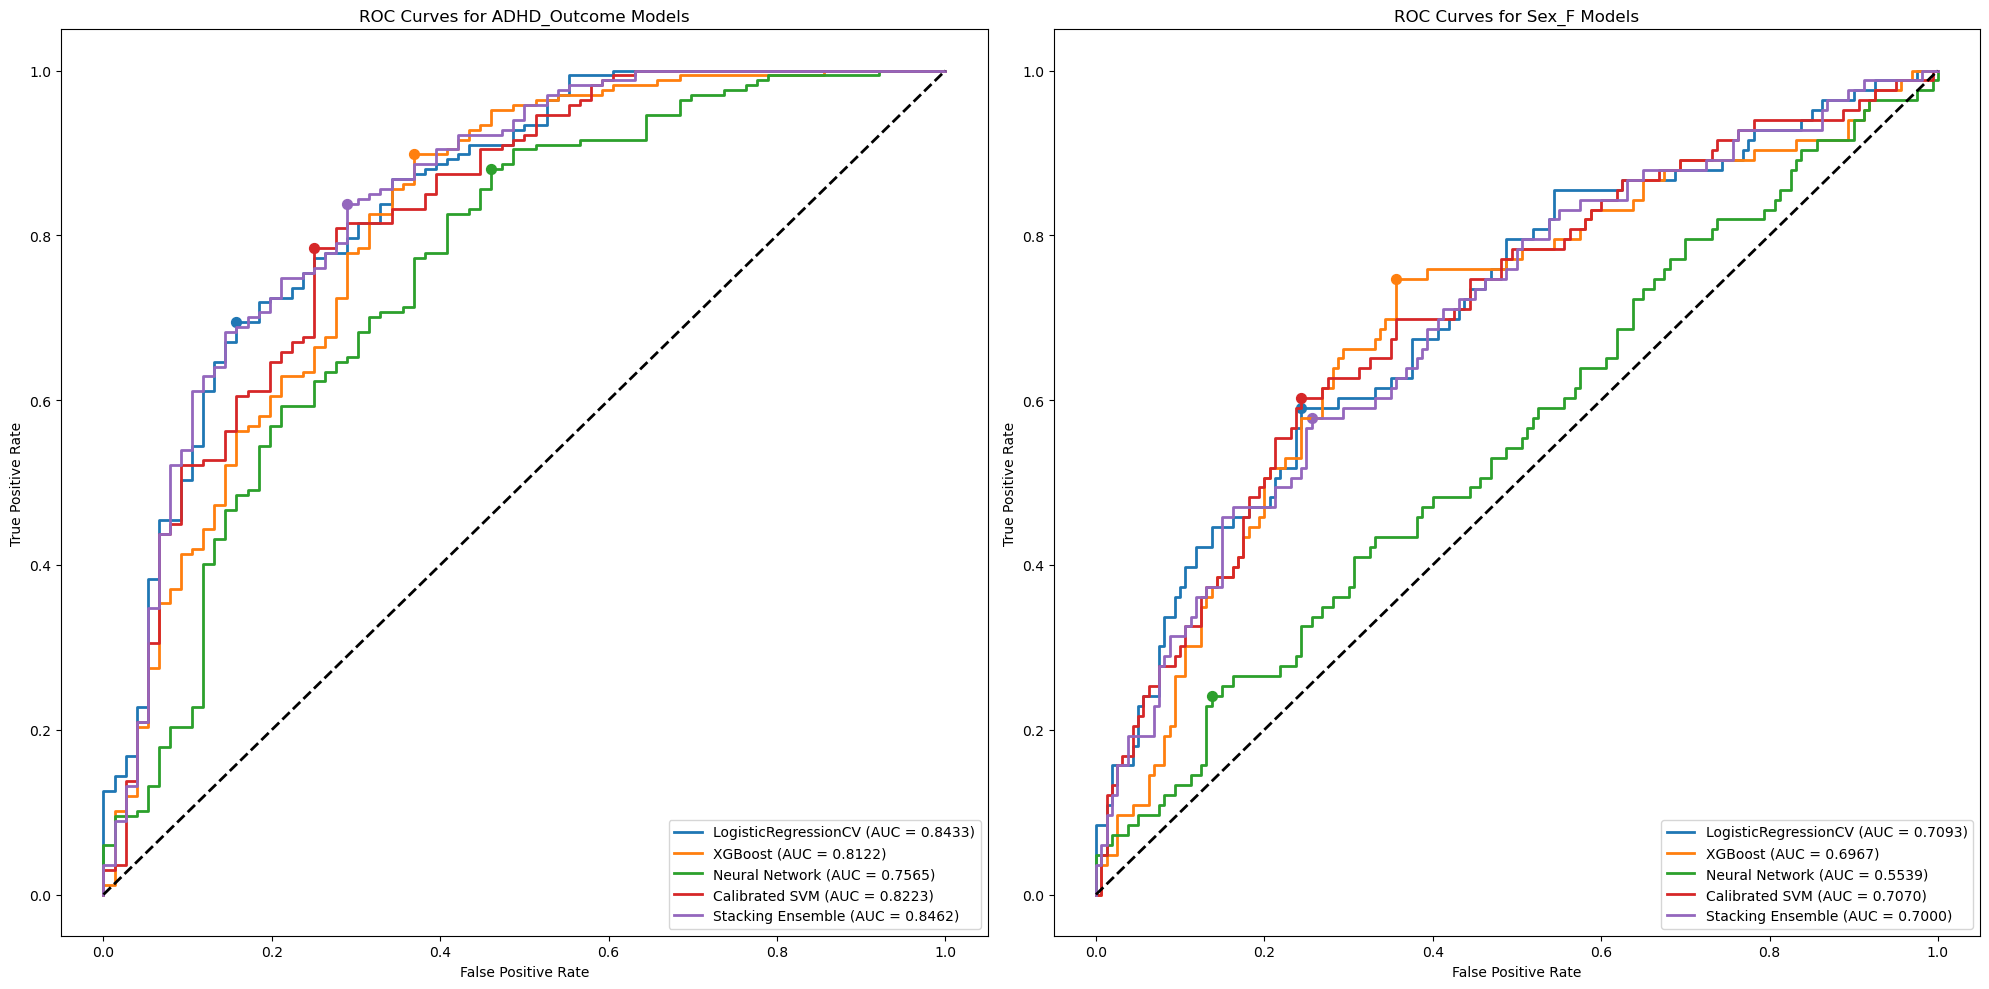

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

def find_optimal_threshold(y_true, y_prob, metric='f1'):
    """
    Find the optimal threshold that maximizes a given metric.
    
    Parameters:
        y_true: True binary labels
        y_prob: Predicted probabilities
        metric: Metric to optimize ('f1', 'accuracy', 'precision', 'recall', or 'balanced')
    
    Returns:
        Optimal threshold
    """
    # Get precision, recall, thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    
    # Add threshold=1.0 to match the length of precision and recall
    thresholds = np.append(thresholds, 1.0)
    
    # Calculate F1 scores
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    
    # Calculate accuracies for each threshold
    accuracies = []
    balanced_scores = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        # Overall accuracy
        acc = accuracy_score(y_true, y_pred)
        accuracies.append(acc)
        
        # Balanced score (mean of sensitivity and specificity)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        balanced = (sensitivity + specificity) / 2
        balanced_scores.append(balanced)
    
    # Find optimal threshold based on selected metric
    if metric == 'f1':
        optimal_idx = np.argmax(f1_scores)
    elif metric == 'accuracy':
        optimal_idx = np.argmax(accuracies)
    elif metric == 'precision':
        optimal_idx = np.argmax(precisions)
    elif metric == 'recall':
        optimal_idx = np.argmax(recalls)
    elif metric == 'balanced':
        optimal_idx = np.argmax(balanced_scores)
    else:
        raise ValueError(f"Unknown metric: {metric}")
    
    return thresholds[optimal_idx]

def multi_model_comparison(output_filename='multi_model_comparison.csv', test_dataset=None):
    """
    Compare multiple models with custom thresholds for multi-outcome prediction.
    
    Parameters:
        output_filename: Name of the file to save predictions
        test_dataset: Test DataFrame. If None, will try to load from 'test_df_50.csv'
    """
    try:
        # Load the training dataset
        try:
            # First try to load the selected features dataset
            train_df = pd.read_csv('selected_features_dual_target.csv')
            print("Using the filtered features dataset for training.")
        except:
            # If not available, use the original dataset
            train_df = pd.read_csv('train_df_50.csv')
            print("Using the original dataset for training.")
        
        print(f"Training data shape: {train_df.shape}")
        
        # Use the provided test dataset or try to load it
        try:
            # First use the provided test_dataset parameter if available
            if test_dataset is not None:
                test_df = test_dataset
                print("Using provided test dataset parameter.")
            # Next try to access the global test_df if it exists
            elif 'test_df' in globals():
                test_df = globals()['test_df']
                print("Using existing global test_df variable.")
            # Finally try to load it from a file
            else:
                test_df = pd.read_csv('test_df_50.csv')
                print("Loaded test_df from file.")
            
            print(f"Test data shape: {test_df.shape}")
        except Exception as e:
            print(f"Error with test dataset: {e}")
            print("Please ensure test_df is defined or 'test_df_50.csv' is available.")
            return None
        
        # Extract columns
        target_columns = ["ADHD_Outcome", "Sex_F"]
        feature_columns = [col for col in train_df.columns if col not in target_columns and col != 'participant_id']
        print(f"Number of features: {len(feature_columns)}")
        
        # Make sure test data has all needed feature columns
        missing_columns = [col for col in feature_columns if col not in test_df.columns]
        if missing_columns:
            print(f"Warning: Test data is missing these columns: {missing_columns}")
            feature_columns = [col for col in feature_columns if col not in missing_columns]
        
        # Prepare the data
        X_train = train_df[feature_columns]
        y_train = train_df[target_columns].values
        X_test = test_df[feature_columns].copy() if all(col in test_df.columns for col in feature_columns) else \
                 pd.DataFrame(index=test_df.index, columns=feature_columns)
        
        # Check for missing values
        train_nan_count = X_train.isnull().sum().sum()
        test_nan_count = X_test.isnull().sum().sum()
        print(f"\nTraining data NaN values: {train_nan_count}")
        print(f"Test data NaN values: {test_nan_count}")
        
        # -----------------------------------------------------------------------------
        # Data Preprocessing with NaN handling
        # -----------------------------------------------------------------------------
        print("\nPreprocessing data with NaN handling...")
        
        # 1. Impute missing values using SimpleImputer with mean strategy
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        
        # 2. Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)
        
        # Verify no NaNs remain
        print(f"NaNs in training data after imputation: {np.isnan(X_train_scaled).sum()}")
        print(f"NaNs in test data after imputation: {np.isnan(X_test_scaled).sum()}")
        
        # Handle any remaining NaNs
        if np.isnan(X_train_scaled).any():
            print("Replacing remaining NaNs in training data with zeros...")
            X_train_scaled = np.nan_to_num(X_train_scaled)
        
        if np.isnan(X_test_scaled).any():
            print("Replacing remaining NaNs in test data with zeros...")
            X_test_scaled = np.nan_to_num(X_test_scaled)
        
        # Split training data for validation
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
        )
        
        # -----------------------------------------------------------------------------
        # Define Multiple Models
        # -----------------------------------------------------------------------------
        print("\nSetting up multiple models for comparison...")
        
        # Model 1: Logistic Regression CV
        print("Initializing LogisticRegressionCV...")
        logistic_cv_adhd = LogisticRegressionCV(
            cv=5, random_state=42, max_iter=2000, class_weight='balanced', n_jobs=-1
        )
        
        logistic_cv_sex = LogisticRegressionCV(
            cv=5, random_state=42, max_iter=2000, class_weight='balanced', n_jobs=-1
        )
        
        # Model 2: XGBoost
        print("Initializing XGBoost...")
        xgb_adhd = xgb.XGBClassifier(
            objective='binary:logistic', 
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        
        xgb_sex = xgb.XGBClassifier(
            objective='binary:logistic', 
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        
        # Model 3: Neural Network (MLP)
        print("Initializing Neural Network...")
        nn_adhd = MLPClassifier(
            hidden_layer_sizes=(100, 50), 
            activation='relu', 
            random_state=42,
            max_iter=1000
        )
        
        nn_sex = MLPClassifier(
            hidden_layer_sizes=(100, 50), 
            activation='relu', 
            random_state=42,
            max_iter=1000
        )
        
        # Model 4: SVM with Calibration
        print("Initializing SVM with calibration...")
        svm_adhd = CalibratedClassifierCV(
            SVC(probability=True, random_state=42),
            cv=5
        )
        
        svm_sex = CalibratedClassifierCV(
            SVC(probability=True, random_state=42),
            cv=5
        )
        
        # Model 5: Ensemble (Stacking)
        print("Initializing Stacking Ensemble...")
        
        # Define base estimators for ADHD prediction
        estimators_adhd = [
            ('lr', LogisticRegressionCV(cv=3, max_iter=1000, random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
        ]
        
        # Define base estimators for Sex prediction
        estimators_sex = [
            ('lr', LogisticRegressionCV(cv=3, max_iter=1000, random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
        ]
        
        # Create stacking models
        stack_adhd = StackingClassifier(
            estimators=estimators_adhd,
            final_estimator=LogisticRegressionCV(cv=3, max_iter=1000, random_state=42),
            cv=3
        )
        
        stack_sex = StackingClassifier(
            estimators=estimators_sex,
            final_estimator=LogisticRegressionCV(cv=3, max_iter=1000, random_state=42),
            cv=3
        )
        
        # -----------------------------------------------------------------------------
        # Train Models and Find Optimal Thresholds
        # -----------------------------------------------------------------------------
        print("\nTraining models and finding optimal thresholds...")
        
        # Define model lists for iteration
        models_adhd = [
            ('LogisticRegressionCV', logistic_cv_adhd),
            ('XGBoost', xgb_adhd),
            ('Neural Network', nn_adhd),
            ('Calibrated SVM', svm_adhd),
            ('Stacking Ensemble', stack_adhd)
        ]
        
        models_sex = [
            ('LogisticRegressionCV', logistic_cv_sex),
            ('XGBoost', xgb_sex),
            ('Neural Network', nn_sex),
            ('Calibrated SVM', svm_sex),
            ('Stacking Ensemble', stack_sex)
        ]
        
        # Dictionaries to store results
        results_adhd = {}
        results_sex = {}
        
        # Train and evaluate ADHD models
        print("\nTraining and evaluating ADHD models...")
        for name, model in models_adhd:
            print(f"Training {name}...")
            try:
                # Train the model
                model.fit(X_train_split, y_train_split[:, 0])
                
                # Predict probabilities
                probs = model.predict_proba(X_val)[:, 1]
                
                # Find optimal threshold
                threshold = find_optimal_threshold(y_val[:, 0], probs, 'balanced')
                
                # Make predictions with custom threshold
                preds = (probs >= threshold).astype(int)
                
                # Calculate accuracy
                acc = accuracy_score(y_val[:, 0], preds)
                
                # Calculate AUC
                auc = roc_auc_score(y_val[:, 0], probs)
                
                # Store results
                results_adhd[name] = {
                    'model': model,
                    'probabilities': probs,
                    'threshold': threshold,
                    'predictions': preds,
                    'accuracy': acc,
                    'auc': auc,
                    'report': classification_report(y_val[:, 0], preds, output_dict=True)
                }
                
                print(f"  {name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}, Threshold: {threshold:.4f}")
                
            except Exception as e:
                print(f"  Error training {name}: {e}")
                continue
        
        # Train and evaluate Sex models
        print("\nTraining and evaluating Sex_F models...")
        for name, model in models_sex:
            print(f"Training {name}...")
            try:
                # Train the model
                model.fit(X_train_split, y_train_split[:, 1])
                
                # Predict probabilities
                probs = model.predict_proba(X_val)[:, 1]
                
                # Find optimal threshold
                threshold = find_optimal_threshold(y_val[:, 1], probs, 'balanced')
                
                # Make predictions with custom threshold
                preds = (probs >= threshold).astype(int)
                
                # Calculate accuracy
                acc = accuracy_score(y_val[:, 1], preds)
                
                # Calculate AUC
                auc = roc_auc_score(y_val[:, 1], probs)
                
                # Store results
                results_sex[name] = {
                    'model': model,
                    'probabilities': probs,
                    'threshold': threshold,
                    'predictions': preds,
                    'accuracy': acc,
                    'auc': auc,
                    'report': classification_report(y_val[:, 1], preds, output_dict=True)
                }
                
                print(f"  {name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}, Threshold: {threshold:.4f}")
                
            except Exception as e:
                print(f"  Error training {name}: {e}")
                continue
        
        # -----------------------------------------------------------------------------
        # Find Best Models
        # -----------------------------------------------------------------------------
        # Find best model for ADHD prediction based on AUC
        best_adhd_model_name = max(results_adhd.items(), key=lambda x: x[1]['auc'])[0]
        best_adhd_model = results_adhd[best_adhd_model_name]['model']
        best_adhd_threshold = results_adhd[best_adhd_model_name]['threshold']
        
        # Find best model for Sex prediction based on AUC
        best_sex_model_name = max(results_sex.items(), key=lambda x: x[1]['auc'])[0]
        best_sex_model = results_sex[best_sex_model_name]['model']
        best_sex_threshold = results_sex[best_sex_model_name]['threshold']
        
        print(f"\nBest ADHD model: {best_adhd_model_name} (AUC: {results_adhd[best_adhd_model_name]['auc']:.4f})")
        print(f"Best Sex_F model: {best_sex_model_name} (AUC: {results_sex[best_sex_model_name]['auc']:.4f})")
        
        # -----------------------------------------------------------------------------
        # Print Detailed Classification Reports
        # -----------------------------------------------------------------------------
        print("\n===== CLASSIFICATION REPORTS FOR ALL MODELS =====")
        
        # Print ADHD classification reports
        print("\nADHD_Outcome Classification Reports:")
        print("-------------------------------------")
        
        for name in results_adhd:
            print(f"\n{name} (Threshold: {results_adhd[name]['threshold']:.4f}):")
            report = results_adhd[name]['report']
            
            # Convert the dictionary format to a readable string format
            print(f"              precision    recall  f1-score   support")
            print(f"           0    {report['0']['precision']:.2f}      {report['0']['recall']:.2f}     {report['0']['f1-score']:.2f}       {report['0']['support']}")
            print(f"           1    {report['1']['precision']:.2f}      {report['1']['recall']:.2f}     {report['1']['f1-score']:.2f}       {report['1']['support']}")
            print(f"    accuracy                         {report['accuracy']:.2f}       {report['macro avg']['support']}")
            print(f"   macro avg    {report['macro avg']['precision']:.2f}      {report['macro avg']['recall']:.2f}     {report['macro avg']['f1-score']:.2f}       {report['macro avg']['support']}")
            print(f"weighted avg    {report['weighted avg']['precision']:.2f}      {report['weighted avg']['recall']:.2f}     {report['weighted avg']['f1-score']:.2f}       {report['weighted avg']['support']}")
        
        # Print Sex classification reports
        print("\nSex_F Classification Reports:")
        print("----------------------------")
        
        for name in results_sex:
            print(f"\n{name} (Threshold: {results_sex[name]['threshold']:.4f}):")
            report = results_sex[name]['report']
            
            # Convert the dictionary format to a readable string format
            print(f"              precision    recall  f1-score   support")
            print(f"           0    {report['0']['precision']:.2f}      {report['0']['recall']:.2f}     {report['0']['f1-score']:.2f}       {report['0']['support']}")
            print(f"           1    {report['1']['precision']:.2f}      {report['1']['recall']:.2f}     {report['1']['f1-score']:.2f}       {report['1']['support']}")
            print(f"    accuracy                         {report['accuracy']:.2f}       {report['macro avg']['support']}")
            print(f"   macro avg    {report['macro avg']['precision']:.2f}      {report['macro avg']['recall']:.2f}     {report['macro avg']['f1-score']:.2f}       {report['macro avg']['support']}")
            print(f"weighted avg    {report['weighted avg']['precision']:.2f}      {report['weighted avg']['recall']:.2f}     {report['weighted avg']['f1-score']:.2f}       {report['weighted avg']['support']}")
        
        # -----------------------------------------------------------------------------
        # Retrain Best Models on Full Dataset
        # -----------------------------------------------------------------------------
        print("\nRetraining best models on full dataset...")
        
        # Retrain best ADHD model
        print(f"Retraining {best_adhd_model_name} for ADHD prediction...")
        best_adhd_model.fit(X_train_scaled, y_train[:, 0])
        
        # Retrain best Sex model
        print(f"Retraining {best_sex_model_name} for Sex_F prediction...")
        best_sex_model.fit(X_train_scaled, y_train[:, 1])
        
        # -----------------------------------------------------------------------------
        # Generate Test Predictions
        # -----------------------------------------------------------------------------
        print("\nGenerating predictions for test data...")
        
        # Generate ADHD predictions
        test_adhd_probs = best_adhd_model.predict_proba(X_test_scaled)[:, 1]
        test_adhd_preds = (test_adhd_probs >= best_adhd_threshold).astype(int)
        
        # Generate Sex predictions
        test_sex_probs = best_sex_model.predict_proba(X_test_scaled)[:, 1]
        test_sex_preds = (test_sex_probs >= best_sex_threshold).astype(int)
        
        # Ensure participant_id is available
        if 'participant_id' not in test_df.columns:
            print("Warning: participant_id column not found in test data. Using row index as ID.")
            participant_ids = np.arange(1, len(test_df) + 1)
        else:
            participant_ids = test_df['participant_id'].values
        
        # Create submission DataFrame
        submission_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Outcome': test_adhd_preds,
            'Sex_F': test_sex_preds
        })
        
        # Create probabilities DataFrame
        probs_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Model': [best_adhd_model_name] * len(test_df),
            'Sex_F_Model': [best_sex_model_name] * len(test_df),
            'ADHD_Threshold': [best_adhd_threshold] * len(test_df),
            'Sex_F_Threshold': [best_sex_threshold] * len(test_df),
            'ADHD_Probability': test_adhd_probs,
            'Sex_F_Probability': test_sex_probs,
            'ADHD_Outcome': test_adhd_preds,
            'Sex_F': test_sex_preds
        })
        
        # Save to CSV
        submission_df.to_csv(output_filename, index=False)
        probs_df.to_csv(output_filename.replace('.csv', '_with_details.csv'), index=False)
        
        print(f"\nPredictions saved to: {output_filename}")
        print(f"Predictions with details saved to: {output_filename.replace('.csv', '_with_details.csv')}")
        print("First 5 rows of the submission file:")
        print(submission_df.head())
        
        # Create ROC curves for all models
        plt.figure(figsize=(20, 10))
        
        # ADHD ROC Curves
        plt.subplot(1, 2, 1)
        for name in results_adhd:
            y_prob = results_adhd[name]['probabilities']
            fpr, tpr, _ = roc_curve(y_val[:, 0], y_prob)
            auc = results_adhd[name]['auc']
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc:.4f})')
            
            # Mark the optimal threshold point
            threshold = results_adhd[name]['threshold']
            idx = (np.abs(np.array(_) - threshold)).argmin()
            if idx < len(fpr):
                plt.scatter(fpr[idx], tpr[idx], marker='o', s=50)
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for ADHD_Outcome Models')
        plt.legend(loc='lower right')
        
        # Sex ROC Curves
        plt.subplot(1, 2, 2)
        for name in results_sex:
            y_prob = results_sex[name]['probabilities']
            fpr, tpr, _ = roc_curve(y_val[:, 1], y_prob)
            auc = results_sex[name]['auc']
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc:.4f})')
            
            # Mark the optimal threshold point
            threshold = results_sex[name]['threshold']
            idx = (np.abs(np.array(_) - threshold)).argmin()
            if idx < len(fpr):
                plt.scatter(fpr[idx], tpr[idx], marker='o', s=50)
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for Sex_F Models')
        plt.legend(loc='lower right')
        
        plt.tight_layout()
        
        # Print summary of best models
        print("\n===== SUMMARY OF BEST MODELS =====")
        print(f"Best ADHD model: {best_adhd_model_name}")
        print(f"  - AUC: {results_adhd[best_adhd_model_name]['auc']:.4f}")
        print(f"  - Accuracy: {results_adhd[best_adhd_model_name]['accuracy']:.4f}")
        print(f"  - Optimal threshold: {best_adhd_threshold:.4f}")
        
        print(f"\nBest Sex_F model: {best_sex_model_name}")
        print(f"  - AUC: {results_sex[best_sex_model_name]['auc']:.4f}")
        print(f"  - Accuracy: {results_sex[best_sex_model_name]['accuracy']:.4f}")
        print(f"  - Optimal threshold: {best_sex_threshold:.4f}")
        
        return {
            'submission': submission_df,
            'probabilities': probs_df,
            'results_adhd': results_adhd,
            'results_sex': results_sex,
            'best_adhd_model': best_adhd_model_name,
            'best_sex_model': best_sex_model_name
        }
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Execute the function
if __name__ == "__main__":
    # Try to access the existing test_df variable if available
    if 'test_df' in globals():
        multi_model_comparison(test_dataset=test_df)
    else:
        multi_model_comparison()

Using the filtered features dataset for training.
Training data shape: (1213, 17)
Using provided test dataset parameter.
Test data shape: (304, 19928)
Original number of features: 15

Training data NaN values: 0
Test data NaN values: 285

Preprocessing data with NaN handling...
Identified 10 behavioral features:
SDQ_SDQ_Hyperactivity, SDQ_SDQ_Externalizing, SDQ_SDQ_Difficulties_Total, SDQ_SDQ_Generating_Impact, SDQ_SDQ_Conduct_Problems, SDQ_SDQ_Internalizing, SDQ_SDQ_Emotional_Problems, SDQ_SDQ_Prosocial, SDQ_SDQ_Peer_Problems, APQ_P_APQ_P_OPD
Created 45 interaction terms between behavioral features
Created 45 interaction terms between behavioral features

Performing feature selection on interaction features...
Selecting features for ADHD_Outcome...
Selecting features for Sex_F...
Selected 12 features for ADHD_Outcome (7 interactions)
Selected 18 features for Sex_F (14 interactions)

Top 5 interaction features for ADHD_Outcome:
  SDQ_SDQ_Hyperactivity*SDQ_SDQ_Externalizing: 0.1220
  SD

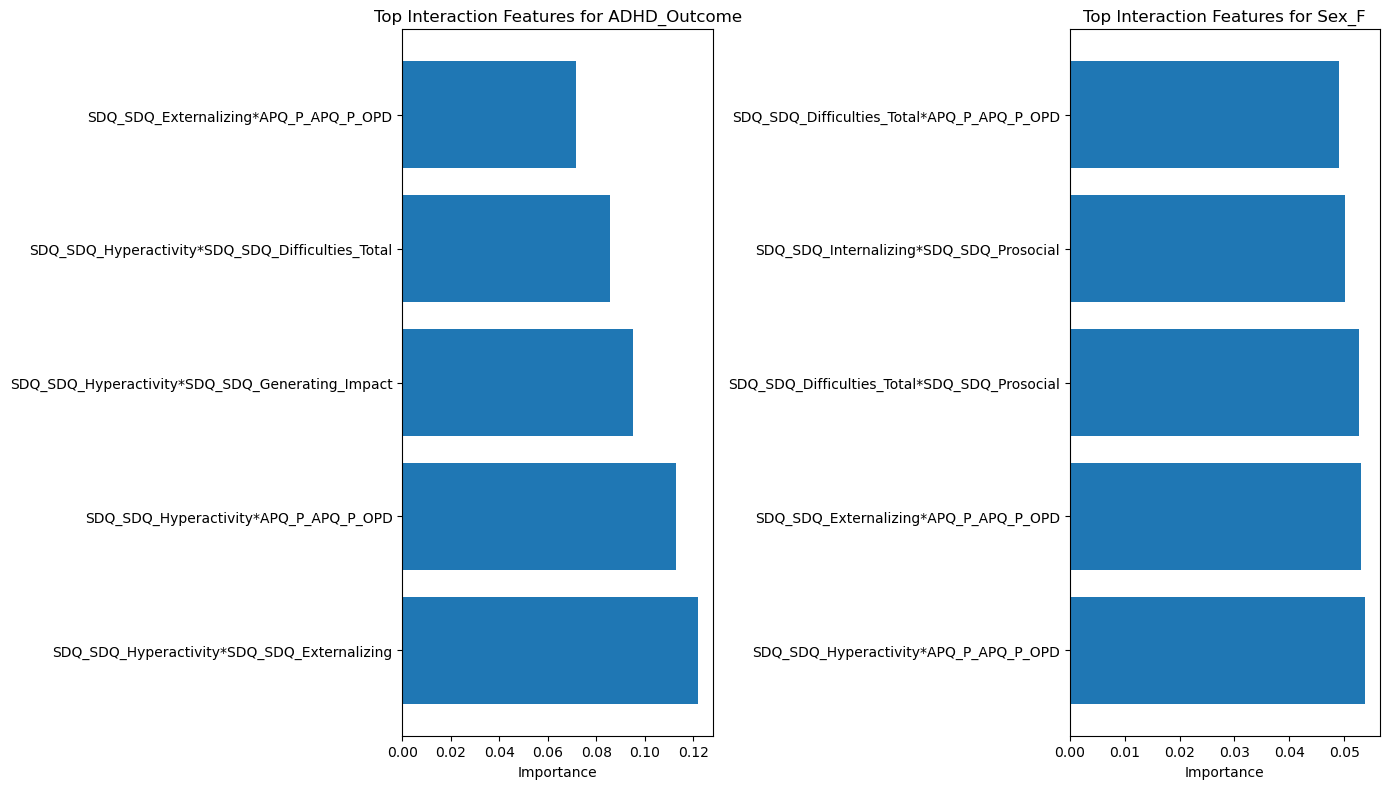

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import xgboost as xgb
from imblearn.combine import SMOTEENN
import itertools
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

def find_optimal_threshold(y_true, y_prob, metric='balanced'):
    """
    Find the optimal threshold that maximizes a given metric.
    """
    thresholds = np.linspace(0.1, 0.9, 100)
    
    best_metric_value = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        
        # Calculate different metrics based on confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = sensitivity
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        balanced = (sensitivity + specificity) / 2
        
        # Select metric to optimize
        if metric == 'balanced':
            metric_value = balanced
        elif metric == 'f1':
            metric_value = f1
        elif metric == 'accuracy':
            metric_value = accuracy
        elif metric == 'precision':
            metric_value = precision
        elif metric == 'recall':
            metric_value = recall
        else:
            metric_value = balanced
            
        # Update best threshold if current is better
        if metric_value > best_metric_value:
            best_metric_value = metric_value
            best_threshold = threshold
            
    return best_threshold

def print_formatted_output(submission_df):
    """
    Print the submission dataframe in the format:
    participant_id,ADHD_Outcome,Sex_F
    v1nMpCoLGU0V, 1, 1
    """
    print("participant_id,ADHD_Outcome,Sex_F")
    for _, row in submission_df.iterrows():
        print(f"{row['participant_id']}, {row['ADHD_Outcome']}, {row['Sex_F']}")

def identify_behavioral_features(feature_names):
    """
    Identify behavioral features based on their names.
    Focuses on features that likely represent behavioral characteristics.
    
    Returns:
        List of behavioral feature names
    """
    behavioral_keywords = [
        'SDQ', 'EHQ', 'APQ', 'behavior', 'conduct', 
        'hyperactivity', 'attention', 'emotional',
        'social', 'peer', 'activity', 'anxiety', 'depression',
        'impulsivity', 'externalizing', 'internalizing',
        'difficulties', 'impact', 'generating'
    ]
    
    # Identify behavioral features
    behavioral_features = []
    for feature in feature_names:
        if any(keyword.lower() in feature.lower() for keyword in behavioral_keywords):
            behavioral_features.append(feature)
    
    return behavioral_features

def create_interaction_features(X, behavioral_features, feature_names, max_interactions=50):
    """
    Create interaction terms between behavioral features.
    
    Parameters:
        X: Feature matrix
        behavioral_features: List of behavioral feature names
        feature_names: List of all feature names
        max_interactions: Maximum number of interaction terms to create
    
    Returns:
        X_with_interactions: Feature matrix with interaction terms
        interaction_names: Names of the interaction features
        all_feature_names: List of all feature names including interactions
    """
    # Get indices of behavioral features
    behavioral_indices = [feature_names.index(f) for f in behavioral_features if f in feature_names]
    
    # Create interaction terms
    interaction_pairs = list(itertools.combinations(behavioral_indices, 2))
    
    # Limit number of interactions if needed
    if len(interaction_pairs) > max_interactions:
        np.random.seed(42)
        interaction_pairs = np.random.choice(interaction_pairs, max_interactions, replace=False)
    
    # Create interaction terms
    X_with_interactions = X.copy()
    interaction_names = []
    
    for i, j in interaction_pairs:
        interaction_term = X[:, i] * X[:, j]
        X_with_interactions = np.column_stack((X_with_interactions, interaction_term))
        interaction_names.append(f"{feature_names[i]}*{feature_names[j]}")
    
    print(f"Created {len(interaction_names)} interaction terms between behavioral features")
    
    # Create full list of feature names including interactions
    all_feature_names = feature_names + interaction_names
    
    return X_with_interactions, interaction_names, all_feature_names

def multi_outcome_with_interactions_fixed(output_filename='feature_interaction_predictions.csv', test_dataset=None):
    """
    Multi-outcome prediction with feature interactions and SMOTE-ENN.
    Fixed version with proper feature importance handling.
    
    Parameters:
        output_filename: Name of the file to save predictions
        test_dataset: Test DataFrame. If None, will try to load from 'test_df_50.csv'
    
    Returns:
        Dictionary with results including submission DataFrame
    """
    try:
        # Load the training dataset
        try:
            # First try to load the selected features dataset
            train_df = pd.read_csv('selected_features_dual_target.csv')
            print("Using the filtered features dataset for training.")
        except:
            # If not available, use the original dataset
            train_df = pd.read_csv('train_df_50.csv')
            print("Using the original dataset for training.")
        
        print(f"Training data shape: {train_df.shape}")
        
        # Use the provided test dataset or try to load it
        try:
            # First use the provided test_dataset parameter if available
            if test_dataset is not None:
                test_df = test_dataset
                print("Using provided test dataset parameter.")
            # Next try to access the global test_df if it exists
            elif 'test_df' in globals():
                test_df = globals()['test_df']
                print("Using existing global test_df variable.")
            # Finally try to load it from a file
            else:
                test_df = pd.read_csv('test_df_50.csv')
                print("Loaded test_df from file.")
            
            print(f"Test data shape: {test_df.shape}")
        except Exception as e:
            print(f"Error with test dataset: {e}")
            print("Please ensure test_df is defined or 'test_df_50.csv' is available.")
            return None
        
        # Extract columns
        target_columns = ["ADHD_Outcome", "Sex_F"]
        feature_columns = [col for col in train_df.columns if col not in target_columns and col != 'participant_id']
        print(f"Original number of features: {len(feature_columns)}")
        
        # Make sure test data has all needed feature columns
        missing_columns = [col for col in feature_columns if col not in test_df.columns]
        if missing_columns:
            print(f"Warning: Test data is missing these columns: {missing_columns}")
            feature_columns = [col for col in feature_columns if col not in missing_columns]
        
        # Prepare the data
        X_train = train_df[feature_columns].values
        y_train = train_df[target_columns].values
        X_test = test_df[feature_columns].values if all(col in test_df.columns for col in feature_columns) else \
                 np.zeros((len(test_df), len(feature_columns)))
        
        # Check for missing values
        train_nan_count = np.isnan(X_train).sum()
        test_nan_count = np.isnan(X_test).sum()
        print(f"\nTraining data NaN values: {train_nan_count}")
        print(f"Test data NaN values: {test_nan_count}")
        
        # -----------------------------------------------------------------------------
        # Data Preprocessing with NaN handling
        # -----------------------------------------------------------------------------
        print("\nPreprocessing data with NaN handling...")
        
        # 1. Impute missing values using SimpleImputer with mean strategy
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        
        # 2. Identify behavioral features
        behavioral_features = identify_behavioral_features(feature_columns)
        print(f"Identified {len(behavioral_features)} behavioral features:")
        print(", ".join(behavioral_features[:10]) + ("..." if len(behavioral_features) > 10 else ""))
        
        # 3. Create interaction terms between behavioral features
        X_train_with_interactions, interaction_names, all_feature_names = create_interaction_features(
            X_train_imputed, behavioral_features, feature_columns
        )
        
        X_test_with_interactions, _, _ = create_interaction_features(
            X_test_imputed, behavioral_features, feature_columns
        )
        
        # 4. Standardize all features including interactions
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_with_interactions)
        X_test_scaled = scaler.transform(X_test_with_interactions)
        
        # Handle any remaining NaNs
        if np.isnan(X_train_scaled).any():
            print("Replacing remaining NaNs in training data with zeros...")
            X_train_scaled = np.nan_to_num(X_train_scaled)
        
        if np.isnan(X_test_scaled).any():
            print("Replacing remaining NaNs in test data with zeros...")
            X_test_scaled = np.nan_to_num(X_test_scaled)
        
        # 5. Feature selection to reduce dimensionality
        print("\nPerforming feature selection on interaction features...")
        
        # Initialize feature selectors for each target
        selector_adhd = RFECV(
            estimator=RandomForestClassifier(n_estimators=100, random_state=42),
            step=0.1,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1
        )
        
        selector_sex = RFECV(
            estimator=RandomForestClassifier(n_estimators=100, random_state=42),
            step=0.1,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1
        )
        
        # Fit selectors
        print("Selecting features for ADHD_Outcome...")
        selector_adhd.fit(X_train_scaled, y_train[:, 0])
        
        print("Selecting features for Sex_F...")
        selector_sex.fit(X_train_scaled, y_train[:, 1])
        
        # Get selected features
        X_train_adhd_selected = selector_adhd.transform(X_train_scaled)
        X_test_adhd_selected = selector_adhd.transform(X_test_scaled)
        
        X_train_sex_selected = selector_sex.transform(X_train_scaled)
        X_test_sex_selected = selector_sex.transform(X_test_scaled)
        
        # Get names of selected features
        selected_features_adhd = [all_feature_names[i] for i in np.where(selector_adhd.support_)[0]]
        selected_features_sex = [all_feature_names[i] for i in np.where(selector_sex.support_)[0]]
        
        # Count behavioral interactions in selected features
        adhd_interaction_count = sum(1 for f in selected_features_adhd if '*' in f)
        sex_interaction_count = sum(1 for f in selected_features_sex if '*' in f)
        
        print(f"Selected {len(selected_features_adhd)} features for ADHD_Outcome ({adhd_interaction_count} interactions)")
        print(f"Selected {len(selected_features_sex)} features for Sex_F ({sex_interaction_count} interactions)")
        
        # FIXED PART: Get top interaction features by importance for each outcome
        # For ADHD
        feature_importances_adhd = selector_adhd.estimator_.feature_importances_
        feature_importances_with_names_adhd = list(zip(
            np.array(all_feature_names)[selector_adhd.support_], 
            feature_importances_adhd
        ))
        top_interactions_adhd = [(name, importance) for name, importance in feature_importances_with_names_adhd 
                               if '*' in name]
        top_interactions_adhd = sorted(top_interactions_adhd, key=lambda x: x[1], reverse=True)[:5]
        
        # For Sex_F
        feature_importances_sex = selector_sex.estimator_.feature_importances_
        feature_importances_with_names_sex = list(zip(
            np.array(all_feature_names)[selector_sex.support_], 
            feature_importances_sex
        ))
        top_interactions_sex = [(name, importance) for name, importance in feature_importances_with_names_sex 
                              if '*' in name]
        top_interactions_sex = sorted(top_interactions_sex, key=lambda x: x[1], reverse=True)[:5]
        
        # Print top interaction features
        if top_interactions_adhd:
            print("\nTop 5 interaction features for ADHD_Outcome:")
            for name, importance in top_interactions_adhd:
                print(f"  {name}: {importance:.4f}")
        else:
            print("\nNo interaction features selected for ADHD_Outcome")
            
        if top_interactions_sex:
            print("\nTop 5 interaction features for Sex_F:")
            for name, importance in top_interactions_sex:
                print(f"  {name}: {importance:.4f}")
        else:
            print("\nNo interaction features selected for Sex_F")
        
        # Split training data for validation
        X_train_adhd_split, X_val_adhd, y_train_adhd_split, y_val_adhd = train_test_split(
            X_train_adhd_selected, y_train[:, 0], test_size=0.2, random_state=42, stratify=y_train[:, 0]
        )
        
        X_train_sex_split, X_val_sex, y_train_sex_split, y_val_sex = train_test_split(
            X_train_sex_selected, y_train[:, 1], test_size=0.2, random_state=42, stratify=y_train[:, 1]
        )
        
        # -----------------------------------------------------------------------------
        # Apply SMOTE-ENN For Balanced Sampling
        # -----------------------------------------------------------------------------
        print("\nApplying SMOTE-ENN for balanced sampling...")
        
        # Initialize SMOTE-ENN with conservative parameters
        smote_enn_adhd = SMOTEENN(random_state=42, sampling_strategy='auto', n_jobs=-1)
        smote_enn_sex = SMOTEENN(random_state=42, sampling_strategy='auto', n_jobs=-1)
        
        # Apply SMOTE-ENN to ADHD target
        print("Balancing ADHD_Outcome data...")
        X_adhd_resampled, y_adhd_resampled = smote_enn_adhd.fit_resample(X_train_adhd_split, y_train_adhd_split)
        
        # Apply SMOTE-ENN to Sex_F target
        print("Balancing Sex_F data...")
        X_sex_resampled, y_sex_resampled = smote_enn_sex.fit_resample(X_train_sex_split, y_train_sex_split)
        
        # Print resampling statistics
        print(f"Original ADHD class distribution: {np.bincount(y_train_adhd_split)}")
        print(f"Resampled ADHD class distribution: {np.bincount(y_adhd_resampled)}")
        print(f"Original Sex_F class distribution: {np.bincount(y_train_sex_split)}")
        print(f"Resampled Sex_F class distribution: {np.bincount(y_sex_resampled)}")
        
        # -----------------------------------------------------------------------------
        # Train Models with Feature Interactions
        # -----------------------------------------------------------------------------
        print("\nTraining models with feature interactions...")
        
        # ADHD model with XGBoost
        print("Training XGBoost model for ADHD_Outcome...")
        xgb_adhd = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=200,
            random_state=42
        )
        xgb_adhd.fit(X_adhd_resampled, y_adhd_resampled)
        
        # Sex_F model with XGBoost
        print("Training XGBoost model for Sex_F...")
        xgb_sex = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=200,
            random_state=42
        )
        xgb_sex.fit(X_sex_resampled, y_sex_resampled)
        
        # -----------------------------------------------------------------------------
        # Evaluate Models and Find Optimal Thresholds
        # -----------------------------------------------------------------------------
        print("\nEvaluating models and finding optimal thresholds...")
        
        # ADHD model evaluation
        adhd_probs = xgb_adhd.predict_proba(X_val_adhd)[:, 1]
        adhd_threshold = find_optimal_threshold(y_val_adhd, adhd_probs, 'balanced')
        adhd_preds = (adhd_probs >= adhd_threshold).astype(int)
        
        # Calculate ADHD metrics
        adhd_acc = accuracy_score(y_val_adhd, adhd_preds)
        adhd_auc = roc_auc_score(y_val_adhd, adhd_probs)
        
        # Get ADHD confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_val_adhd, adhd_preds).ravel()
        adhd_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        adhd_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        adhd_balanced_acc = (adhd_sensitivity + adhd_specificity) / 2
        
        # Sex_F model evaluation
        sex_probs = xgb_sex.predict_proba(X_val_sex)[:, 1]
        sex_threshold = find_optimal_threshold(y_val_sex, sex_probs, 'balanced')
        sex_preds = (sex_probs >= sex_threshold).astype(int)
        
        # Calculate Sex_F metrics
        sex_acc = accuracy_score(y_val_sex, sex_preds)
        sex_auc = roc_auc_score(y_val_sex, sex_probs)
        
        # Get Sex_F confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_val_sex, sex_preds).ravel()
        sex_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        sex_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sex_balanced_acc = (sex_sensitivity + sex_specificity) / 2
        
        # Print evaluation results
        print("\nValidation Results:")
        print(f"ADHD_Outcome - Acc: {adhd_acc:.4f}, AUC: {adhd_auc:.4f}, Sens: {adhd_sensitivity:.4f}, Spec: {adhd_specificity:.4f}")
        print(f"ADHD_Outcome - Balanced Accuracy: {adhd_balanced_acc:.4f}, Threshold: {adhd_threshold:.4f}")
        print(f"Sex_F - Acc: {sex_acc:.4f}, AUC: {sex_auc:.4f}, Sens: {sex_sensitivity:.4f}, Spec: {sex_specificity:.4f}")
        print(f"Sex_F - Balanced Accuracy: {sex_balanced_acc:.4f}, Threshold: {sex_threshold:.4f}")
        
        # Classification reports
        print("\nADHD_Outcome Classification Report:")
        print(classification_report(y_val_adhd, adhd_preds))
        
        print("\nSex_F Classification Report:")
        print(classification_report(y_val_sex, sex_preds))
        
        # -----------------------------------------------------------------------------
        # Retrain on Full Dataset
        # -----------------------------------------------------------------------------
        print("\nRetraining models on full dataset...")
        
        # Apply SMOTE-ENN to full datasets
        X_train_adhd_full_resampled, y_train_adhd_full_resampled = smote_enn_adhd.fit_resample(
            X_train_adhd_selected, y_train[:, 0]
        )
        
        X_train_sex_full_resampled, y_train_sex_full_resampled = smote_enn_sex.fit_resample(
            X_train_sex_selected, y_train[:, 1]
        )
        
        # Train final models
        final_xgb_adhd = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=300,  # Increased for final model
            random_state=42
        )
        final_xgb_adhd.fit(X_train_adhd_full_resampled, y_train_adhd_full_resampled)
        
        final_xgb_sex = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=300,  # Increased for final model
            random_state=42
        )
        final_xgb_sex.fit(X_train_sex_full_resampled, y_train_sex_full_resampled)
        
        # -----------------------------------------------------------------------------
        # Generate Test Predictions
        # -----------------------------------------------------------------------------
        print("\nGenerating predictions for test data...")
        
        # Generate predictions with custom thresholds
        test_adhd_probs = final_xgb_adhd.predict_proba(X_test_adhd_selected)[:, 1]
        test_adhd_preds = (test_adhd_probs >= adhd_threshold).astype(int)
        
        test_sex_probs = final_xgb_sex.predict_proba(X_test_sex_selected)[:, 1]
        test_sex_preds = (test_sex_probs >= sex_threshold).astype(int)
        
        # Ensure participant_id is available
        if 'participant_id' not in test_df.columns:
            print("Warning: participant_id column not found in test data. Using row index as ID.")
            participant_ids = np.arange(1, len(test_df) + 1)
        else:
            participant_ids = test_df['participant_id'].values
        
        # Create submission DataFrame
        submission_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Outcome': test_adhd_preds,
            'Sex_F': test_sex_preds
        })
        
        # Create detailed DataFrame
        details_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Threshold': adhd_threshold,
            'Sex_F_Threshold': sex_threshold,
            'ADHD_Probability': test_adhd_probs,
            'Sex_F_Probability': test_sex_probs,
            'ADHD_Outcome': test_adhd_preds,
            'Sex_F': test_sex_preds
        })
        
        # Save to CSV
        submission_df.to_csv(output_filename, index=False)
        details_df.to_csv(output_filename.replace('.csv', '_with_details.csv'), index=False)
        
        print(f"\nPredictions saved to: {output_filename}")
        print(f"Detailed predictions saved to: {output_filename.replace('.csv', '_with_details.csv')}")
        
        # Print the formatted output
        print("\nFormatted predictions:")
        print_formatted_output(submission_df)
        
        # FIXED: Create feature importance visualizations properly
        # Only plot if there are interaction features
        if adhd_interaction_count > 0 or sex_interaction_count > 0:
            plt.figure(figsize=(14, 8))
            
            # For ADHD
            if adhd_interaction_count > 0:
                plt.subplot(1, 2, 1)
                
                # Limit to top 10 interaction features or all if less than 10
                plot_n = min(10, len(top_interactions_adhd))
                names = [name for name, _ in top_interactions_adhd[:plot_n]]
                importances = [importance for _, importance in top_interactions_adhd[:plot_n]]
                
                y_pos = range(len(names))
                plt.barh(y_pos, importances, align='center')
                plt.yticks(y_pos, names)
                plt.title('Top Interaction Features for ADHD_Outcome')
                plt.xlabel('Importance')
                plt.tight_layout()
            
            # For Sex_F
            if sex_interaction_count > 0:
                plt.subplot(1, 2, 2)
                
                # Limit to top 10 interaction features or all if less than 10
                plot_n = min(10, len(top_interactions_sex))
                names = [name for name, _ in top_interactions_sex[:plot_n]]
                importances = [importance for _, importance in top_interactions_sex[:plot_n]]
                
                y_pos = range(len(names))
                plt.barh(y_pos, importances, align='center')
                plt.yticks(y_pos, names)
                plt.title('Top Interaction Features for Sex_F')
                plt.xlabel('Importance')
                plt.tight_layout()
            
            plt.savefig('interaction_feature_importance.png')
            print("Feature importance plot saved to: interaction_feature_importance.png")
        
        # Return results
        return {
            'submission_df': submission_df,
            'details_df': details_df,
            'adhd_metrics': {
                'accuracy': adhd_acc,
                'auc': adhd_auc,
                'sensitivity': adhd_sensitivity,
                'specificity': adhd_specificity,
                'balanced_accuracy': adhd_balanced_acc,
                'threshold': adhd_threshold
            },
            'sex_metrics': {
                'accuracy': sex_acc,
                'auc': sex_auc,
                'sensitivity': sex_sensitivity,
                'specificity': sex_specificity,
                'balanced_accuracy': sex_balanced_acc,
                'threshold': sex_threshold
            },
            'selected_features_adhd': selected_features_adhd,
            'selected_features_sex': selected_features_sex,
            'top_interactions_adhd': top_interactions_adhd,
            'top_interactions_sex': top_interactions_sex
        }
    
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Execute the function if run directly
if __name__ == "__main__":
    # Try to access the existing test_df variable if available
    if 'test_df' in globals():
        results = multi_outcome_with_interactions_fixed(test_dataset=test_df)
    else:
        results = multi_outcome_with_interactions_fixed()

Using the filtered features dataset for training.
Training data shape: (1213, 17)
Using provided test dataset parameter.
Test data shape: (304, 19928)
Original number of features: 15

Training data NaN values: 0
Test data NaN values: 285

Preprocessing data with NaN handling...
Identified 10 behavioral features:
SDQ_SDQ_Hyperactivity, SDQ_SDQ_Externalizing, SDQ_SDQ_Difficulties_Total, SDQ_SDQ_Generating_Impact, SDQ_SDQ_Conduct_Problems, SDQ_SDQ_Internalizing, SDQ_SDQ_Emotional_Problems, SDQ_SDQ_Prosocial, SDQ_SDQ_Peer_Problems, APQ_P_APQ_P_OPD
Created 45 interaction terms between behavioral features
Created 45 interaction terms between behavioral features

Performing feature selection on interaction features...
Selecting features for ADHD_Outcome...
Selecting features for Sex_F...
Selected 12 features for ADHD_Outcome (7 interactions)
Selected 18 features for Sex_F (14 interactions)

Applying SMOTE-ENN for balanced sampling...
Balancing ADHD_Outcome data...
Balancing Sex_F data...
Orig

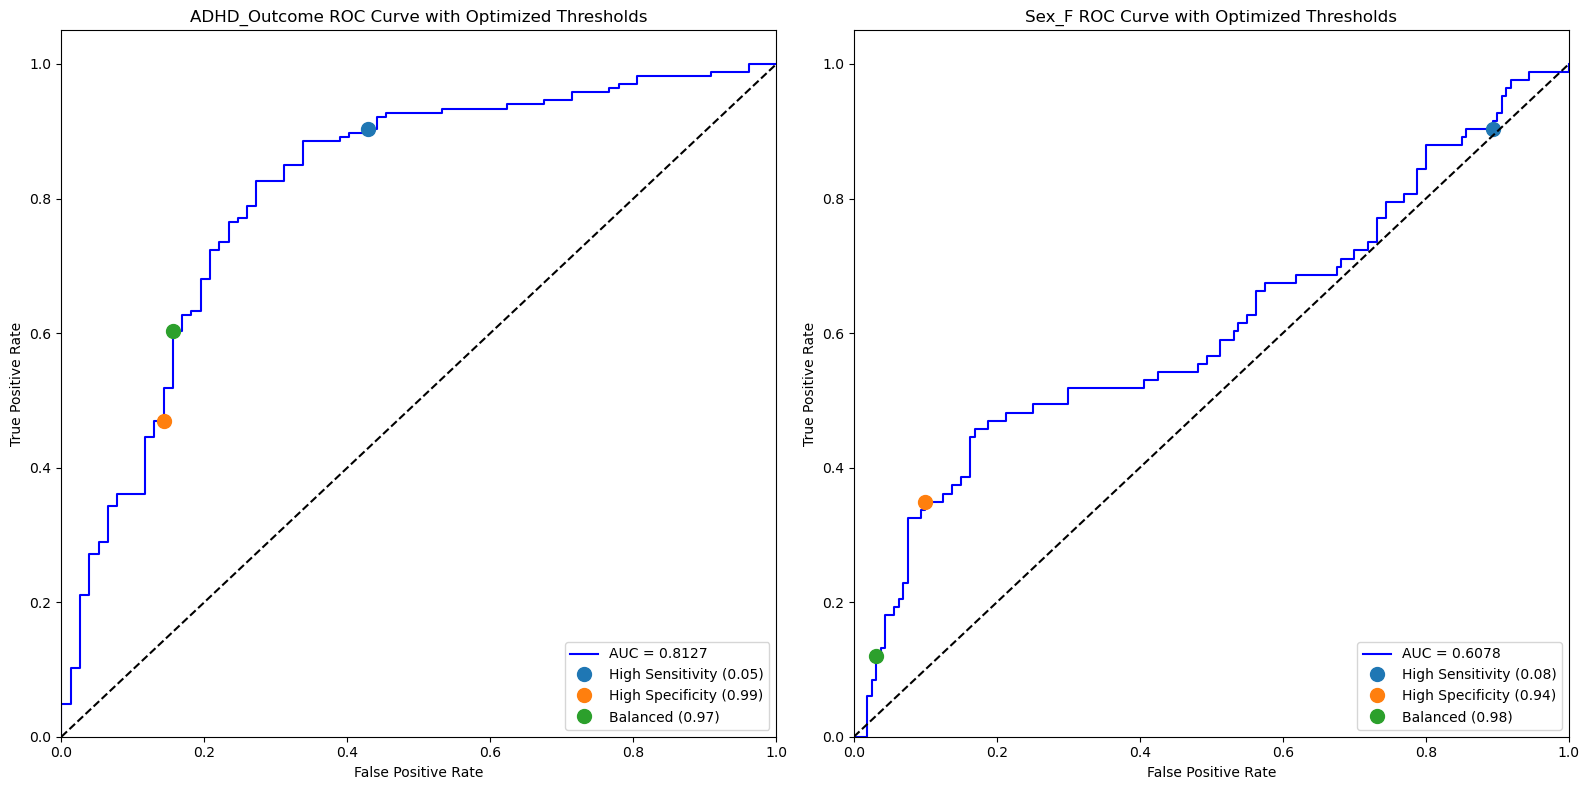

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import xgboost as xgb
from imblearn.combine import SMOTEENN
import itertools
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

def find_optimal_threshold_for_metric(y_true, y_prob, target_metric='sensitivity', target_value=0.90):
    """
    Find the optimal threshold that achieves a target value for a specific metric.
    
    Parameters:
        y_true: True binary labels
        y_prob: Predicted probabilities
        target_metric: 'sensitivity', 'specificity', 'precision', or 'npv' (negative predictive value)
        target_value: Target value for the metric (e.g., 0.90 for 90% sensitivity)
    
    Returns:
        optimal_threshold: Threshold that gets closest to target value
        achieved_value: Actual value achieved for the target metric
        other_metrics: Dictionary with values for other metrics at this threshold
    """
    # Define a range of thresholds to try
    thresholds = np.linspace(0.01, 0.99, 99)
    
    # Initialize variables to track the optimal threshold
    min_distance = float('inf')
    optimal_threshold = 0.5
    achieved_value = 0
    other_metrics = {}
    
    # Evaluate each threshold
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calculate metrics
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        # Determine the current metric value based on the target metric
        if target_metric == 'sensitivity':
            current_value = sensitivity
        elif target_metric == 'specificity':
            current_value = specificity
        elif target_metric == 'precision':
            current_value = precision
        elif target_metric == 'npv':
            current_value = npv
        else:
            raise ValueError(f"Unknown target metric: {target_metric}")
        
        # Calculate distance from target value
        distance = abs(current_value - target_value)
        
        # Update the optimal threshold if this is closer to the target
        if distance < min_distance:
            min_distance = distance
            optimal_threshold = threshold
            achieved_value = current_value
            other_metrics = {
                'sensitivity': sensitivity,
                'specificity': specificity,
                'precision': precision,
                'npv': npv,
                'accuracy': (tp + tn) / (tp + tn + fp + fn)
            }
    
    return optimal_threshold, achieved_value, other_metrics

def print_formatted_output(submission_df):
    """
    Print the submission dataframe in the format:
    participant_id,ADHD_Outcome,Sex_F
    v1nMpCoLGU0V, 1, 1
    """
    print("participant_id,ADHD_Outcome,Sex_F")
    for _, row in submission_df.iterrows():
        print(f"{row['participant_id']}, {row['ADHD_Outcome']}, {row['Sex_F']}")

def identify_behavioral_features(feature_names):
    """
    Identify behavioral features based on their names.
    Focuses on features that likely represent behavioral characteristics.
    
    Returns:
        List of behavioral feature names
    """
    behavioral_keywords = [
        'SDQ', 'EHQ', 'APQ', 'behavior', 'conduct', 
        'hyperactivity', 'attention', 'emotional',
        'social', 'peer', 'activity', 'anxiety', 'depression',
        'impulsivity', 'externalizing', 'internalizing',
        'difficulties', 'impact', 'generating'
    ]
    
    # Identify behavioral features
    behavioral_features = []
    for feature in feature_names:
        if any(keyword.lower() in feature.lower() for keyword in behavioral_keywords):
            behavioral_features.append(feature)
    
    return behavioral_features

def create_interaction_features(X, behavioral_features, feature_names, max_interactions=50):
    """
    Create interaction terms between behavioral features.
    """
    # Get indices of behavioral features
    behavioral_indices = [feature_names.index(f) for f in behavioral_features if f in feature_names]
    
    # Create interaction terms
    interaction_pairs = list(itertools.combinations(behavioral_indices, 2))
    
    # Limit number of interactions if needed
    if len(interaction_pairs) > max_interactions:
        np.random.seed(42)
        interaction_pairs = np.random.choice(interaction_pairs, max_interactions, replace=False)
    
    # Create interaction terms
    X_with_interactions = X.copy()
    interaction_names = []
    
    for i, j in interaction_pairs:
        interaction_term = X[:, i] * X[:, j]
        X_with_interactions = np.column_stack((X_with_interactions, interaction_term))
        interaction_names.append(f"{feature_names[i]}*{feature_names[j]}")
    
    print(f"Created {len(interaction_names)} interaction terms between behavioral features")
    
    # Create full list of feature names including interactions
    all_feature_names = feature_names + interaction_names
    
    return X_with_interactions, interaction_names, all_feature_names

def optimize_thresholds_separately(output_filename='optimized_thresholds_predictions.csv', test_dataset=None):
    """
    Multi-outcome prediction with feature interactions and separately optimized thresholds
    for sensitivity and specificity.
    
    Parameters:
        output_filename: Name of the file to save predictions
        test_dataset: Test DataFrame. If None, will try to load from 'test_df_50.csv'
    
    Returns:
        Dictionary with results including submission DataFrames for different thresholds
    """
    try:
        # Load the training dataset
        try:
            # First try to load the selected features dataset
            train_df = pd.read_csv('selected_features_dual_target.csv')
            print("Using the filtered features dataset for training.")
        except:
            # If not available, use the original dataset
            train_df = pd.read_csv('train_df_50.csv')
            print("Using the original dataset for training.")
        
        print(f"Training data shape: {train_df.shape}")
        
        # Use the provided test dataset or try to load it
        try:
            # First use the provided test_dataset parameter if available
            if test_dataset is not None:
                test_df = test_dataset
                print("Using provided test dataset parameter.")
            # Next try to access the global test_df if it exists
            elif 'test_df' in globals():
                test_df = globals()['test_df']
                print("Using existing global test_df variable.")
            # Finally try to load it from a file
            else:
                test_df = pd.read_csv('test_df_50.csv')
                print("Loaded test_df from file.")
            
            print(f"Test data shape: {test_df.shape}")
        except Exception as e:
            print(f"Error with test dataset: {e}")
            print("Please ensure test_df is defined or 'test_df_50.csv' is available.")
            return None
        
        # Extract columns
        target_columns = ["ADHD_Outcome", "Sex_F"]
        feature_columns = [col for col in train_df.columns if col not in target_columns and col != 'participant_id']
        print(f"Original number of features: {len(feature_columns)}")
        
        # Make sure test data has all needed feature columns
        missing_columns = [col for col in feature_columns if col not in test_df.columns]
        if missing_columns:
            print(f"Warning: Test data is missing these columns: {missing_columns}")
            feature_columns = [col for col in feature_columns if col not in missing_columns]
        
        # Prepare the data
        X_train = train_df[feature_columns].values
        y_train = train_df[target_columns].values
        X_test = test_df[feature_columns].values if all(col in test_df.columns for col in feature_columns) else \
                 np.zeros((len(test_df), len(feature_columns)))
        
        # Check for missing values
        train_nan_count = np.isnan(X_train).sum()
        test_nan_count = np.isnan(X_test).sum()
        print(f"\nTraining data NaN values: {train_nan_count}")
        print(f"Test data NaN values: {test_nan_count}")
        
        # -----------------------------------------------------------------------------
        # Data Preprocessing with NaN handling
        # -----------------------------------------------------------------------------
        print("\nPreprocessing data with NaN handling...")
        
        # 1. Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        
        # 2. Identify behavioral features
        behavioral_features = identify_behavioral_features(feature_columns)
        print(f"Identified {len(behavioral_features)} behavioral features:")
        print(", ".join(behavioral_features[:10]) + ("..." if len(behavioral_features) > 10 else ""))
        
        # 3. Create interaction terms between behavioral features
        X_train_with_interactions, interaction_names, all_feature_names = create_interaction_features(
            X_train_imputed, behavioral_features, feature_columns
        )
        
        X_test_with_interactions, _, _ = create_interaction_features(
            X_test_imputed, behavioral_features, feature_columns
        )
        
        # 4. Standardize all features including interactions
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_with_interactions)
        X_test_scaled = scaler.transform(X_test_with_interactions)
        
        # Handle any remaining NaNs
        if np.isnan(X_train_scaled).any():
            print("Replacing remaining NaNs in training data with zeros...")
            X_train_scaled = np.nan_to_num(X_train_scaled)
        
        if np.isnan(X_test_scaled).any():
            print("Replacing remaining NaNs in test data with zeros...")
            X_test_scaled = np.nan_to_num(X_test_scaled)
        
        # 5. Feature selection to reduce dimensionality
        print("\nPerforming feature selection on interaction features...")
        
        # Initialize feature selectors for each target
        selector_adhd = RFECV(
            estimator=RandomForestClassifier(n_estimators=100, random_state=42),
            step=0.1,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1
        )
        
        selector_sex = RFECV(
            estimator=RandomForestClassifier(n_estimators=100, random_state=42),
            step=0.1,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1
        )
        
        # Fit selectors
        print("Selecting features for ADHD_Outcome...")
        selector_adhd.fit(X_train_scaled, y_train[:, 0])
        
        print("Selecting features for Sex_F...")
        selector_sex.fit(X_train_scaled, y_train[:, 1])
        
        # Get selected features
        X_train_adhd_selected = selector_adhd.transform(X_train_scaled)
        X_test_adhd_selected = selector_adhd.transform(X_test_scaled)
        
        X_train_sex_selected = selector_sex.transform(X_train_scaled)
        X_test_sex_selected = selector_sex.transform(X_test_scaled)
        
        # Get names of selected features
        selected_features_adhd = [all_feature_names[i] for i in np.where(selector_adhd.support_)[0]]
        selected_features_sex = [all_feature_names[i] for i in np.where(selector_sex.support_)[0]]
        
        # Count behavioral interactions in selected features
        adhd_interaction_count = sum(1 for f in selected_features_adhd if '*' in f)
        sex_interaction_count = sum(1 for f in selected_features_sex if '*' in f)
        
        print(f"Selected {len(selected_features_adhd)} features for ADHD_Outcome ({adhd_interaction_count} interactions)")
        print(f"Selected {len(selected_features_sex)} features for Sex_F ({sex_interaction_count} interactions)")
        
        # Split training data for validation
        X_train_adhd_split, X_val_adhd, y_train_adhd_split, y_val_adhd = train_test_split(
            X_train_adhd_selected, y_train[:, 0], test_size=0.2, random_state=42, stratify=y_train[:, 0]
        )
        
        X_train_sex_split, X_val_sex, y_train_sex_split, y_val_sex = train_test_split(
            X_train_sex_selected, y_train[:, 1], test_size=0.2, random_state=42, stratify=y_train[:, 1]
        )
        
        # -----------------------------------------------------------------------------
        # Apply SMOTE-ENN For Balanced Sampling
        # -----------------------------------------------------------------------------
        print("\nApplying SMOTE-ENN for balanced sampling...")
        
        # Initialize SMOTE-ENN with conservative parameters
        smote_enn_adhd = SMOTEENN(random_state=42, sampling_strategy='auto', n_jobs=-1)
        smote_enn_sex = SMOTEENN(random_state=42, sampling_strategy='auto', n_jobs=-1)
        
        # Apply SMOTE-ENN to ADHD target
        print("Balancing ADHD_Outcome data...")
        X_adhd_resampled, y_adhd_resampled = smote_enn_adhd.fit_resample(X_train_adhd_split, y_train_adhd_split)
        
        # Apply SMOTE-ENN to Sex_F target
        print("Balancing Sex_F data...")
        X_sex_resampled, y_sex_resampled = smote_enn_sex.fit_resample(X_train_sex_split, y_train_sex_split)
        
        # Print resampling statistics
        print(f"Original ADHD class distribution: {np.bincount(y_train_adhd_split)}")
        print(f"Resampled ADHD class distribution: {np.bincount(y_adhd_resampled)}")
        print(f"Original Sex_F class distribution: {np.bincount(y_train_sex_split)}")
        print(f"Resampled Sex_F class distribution: {np.bincount(y_sex_resampled)}")
        
        # -----------------------------------------------------------------------------
        # Train Models with Feature Interactions
        # -----------------------------------------------------------------------------
        print("\nTraining models with feature interactions...")
        
        # ADHD model with XGBoost
        print("Training XGBoost model for ADHD_Outcome...")
        xgb_adhd = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=200,
            random_state=42
        )
        xgb_adhd.fit(X_adhd_resampled, y_adhd_resampled)
        
        # Sex_F model with XGBoost
        print("Training XGBoost model for Sex_F...")
        xgb_sex = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=200,
            random_state=42
        )
        xgb_sex.fit(X_sex_resampled, y_sex_resampled)
        
        # -----------------------------------------------------------------------------
        # Evaluate Models and Find Multiple Optimized Thresholds
        # -----------------------------------------------------------------------------
        print("\nFinding optimal thresholds for different metrics...")
        
        # Get predicted probabilities
        adhd_probs = xgb_adhd.predict_proba(X_val_adhd)[:, 1]
        sex_probs = xgb_sex.predict_proba(X_val_sex)[:, 1]
        
        # ADHD threshold optimizations
        # 1. High sensitivity threshold (e.g., 90%)
        adhd_sens_threshold, adhd_sens_achieved, adhd_sens_metrics = find_optimal_threshold_for_metric(
            y_val_adhd, adhd_probs, 'sensitivity', 0.90
        )
        
        # 2. High specificity threshold (e.g., 90%) 
        adhd_spec_threshold, adhd_spec_achieved, adhd_spec_metrics = find_optimal_threshold_for_metric(
            y_val_adhd, adhd_probs, 'specificity', 0.90
        )
        
        # 3. Balanced threshold (sensitivity = specificity)
        adhd_balanced_threshold, _, adhd_balanced_metrics = find_optimal_threshold_for_metric(
            y_val_adhd, adhd_probs, 'sensitivity', adhd_sens_metrics['specificity']
        )
        
        # Sex_F threshold optimizations
        # 1. High sensitivity threshold (e.g., 90%)
        sex_sens_threshold, sex_sens_achieved, sex_sens_metrics = find_optimal_threshold_for_metric(
            y_val_sex, sex_probs, 'sensitivity', 0.90
        )
        
        # 2. High specificity threshold (e.g., 90%)
        sex_spec_threshold, sex_spec_achieved, sex_spec_metrics = find_optimal_threshold_for_metric(
            y_val_sex, sex_probs, 'specificity', 0.90
        )
        
        # 3. Balanced threshold (sensitivity = specificity)
        sex_balanced_threshold, _, sex_balanced_metrics = find_optimal_threshold_for_metric(
            y_val_sex, sex_probs, 'sensitivity', sex_sens_metrics['specificity']
        )
        
        # Print threshold results
        print("\nADHD_Outcome Thresholds:")
        print(f"High Sensitivity Threshold: {adhd_sens_threshold:.4f}")
        print(f"  Sensitivity: {adhd_sens_metrics['sensitivity']:.4f}, Specificity: {adhd_sens_metrics['specificity']:.4f}")
        print(f"  Accuracy: {adhd_sens_metrics['accuracy']:.4f}")
        
        print(f"High Specificity Threshold: {adhd_spec_threshold:.4f}")
        print(f"  Sensitivity: {adhd_spec_metrics['sensitivity']:.4f}, Specificity: {adhd_spec_metrics['specificity']:.4f}")
        print(f"  Accuracy: {adhd_spec_metrics['accuracy']:.4f}")
        
        print(f"Balanced Threshold: {adhd_balanced_threshold:.4f}")
        print(f"  Sensitivity: {adhd_balanced_metrics['sensitivity']:.4f}, Specificity: {adhd_balanced_metrics['specificity']:.4f}")
        print(f"  Accuracy: {adhd_balanced_metrics['accuracy']:.4f}")
        
        print("\nSex_F Thresholds:")
        print(f"High Sensitivity Threshold: {sex_sens_threshold:.4f}")
        print(f"  Sensitivity: {sex_sens_metrics['sensitivity']:.4f}, Specificity: {sex_sens_metrics['specificity']:.4f}")
        print(f"  Accuracy: {sex_sens_metrics['accuracy']:.4f}")
        
        print(f"High Specificity Threshold: {sex_spec_threshold:.4f}")
        print(f"  Sensitivity: {sex_spec_metrics['sensitivity']:.4f}, Specificity: {sex_spec_metrics['specificity']:.4f}")
        print(f"  Accuracy: {sex_spec_metrics['accuracy']:.4f}")
        
        print(f"Balanced Threshold: {sex_balanced_threshold:.4f}")
        print(f"  Sensitivity: {sex_balanced_metrics['sensitivity']:.4f}, Specificity: {sex_balanced_metrics['specificity']:.4f}")
        print(f"  Accuracy: {sex_balanced_metrics['accuracy']:.4f}")
        
        # Calculate AUC scores
        adhd_auc = roc_auc_score(y_val_adhd, adhd_probs)
        sex_auc = roc_auc_score(y_val_sex, sex_probs)
        print(f"\nADHD_Outcome AUC: {adhd_auc:.4f}")
        print(f"Sex_F AUC: {sex_auc:.4f}")
        
        # -----------------------------------------------------------------------------
        # Visualize ROC curves with thresholds
        # -----------------------------------------------------------------------------
        plt.figure(figsize=(16, 8))
        
        # ADHD ROC curve
        plt.subplot(1, 2, 1)
        fpr, tpr, thresholds = roc_curve(y_val_adhd, adhd_probs)
        plt.plot(fpr, tpr, 'b-', label=f'AUC = {adhd_auc:.4f}')
        
        # Mark thresholds on the curve
        for name, threshold in [
            ('High Sensitivity', adhd_sens_threshold),
            ('High Specificity', adhd_spec_threshold),
            ('Balanced', adhd_balanced_threshold)
        ]:
            # Find the closest threshold
            idx = np.argmin(np.abs(thresholds - threshold))
            plt.plot(fpr[idx], tpr[idx], 'o', markersize=10, label=f'{name} ({threshold:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ADHD_Outcome ROC Curve with Optimized Thresholds')
        plt.legend(loc="lower right")
        
        # Sex_F ROC curve
        plt.subplot(1, 2, 2)
        fpr, tpr, thresholds = roc_curve(y_val_sex, sex_probs)
        plt.plot(fpr, tpr, 'b-', label=f'AUC = {sex_auc:.4f}')
        
        # Mark thresholds on the curve
        for name, threshold in [
            ('High Sensitivity', sex_sens_threshold),
            ('High Specificity', sex_spec_threshold),
            ('Balanced', sex_balanced_threshold)
        ]:
            # Find the closest threshold
            idx = np.argmin(np.abs(thresholds - threshold))
            plt.plot(fpr[idx], tpr[idx], 'o', markersize=10, label=f'{name} ({threshold:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Sex_F ROC Curve with Optimized Thresholds')
        plt.legend(loc="lower right")
        
        plt.tight_layout()
        plt.savefig('threshold_optimization.png')
        print("\nThreshold optimization plot saved to: threshold_optimization.png")
        
        # -----------------------------------------------------------------------------
        # Retrain on Full Dataset
        # -----------------------------------------------------------------------------
        print("\nRetraining models on full dataset...")
        
        # Apply SMOTE-ENN to full datasets
        X_train_adhd_full_resampled, y_train_adhd_full_resampled = smote_enn_adhd.fit_resample(
            X_train_adhd_selected, y_train[:, 0]
        )
        
        X_train_sex_full_resampled, y_train_sex_full_resampled = smote_enn_sex.fit_resample(
            X_train_sex_selected, y_train[:, 1]
        )
        
        # Train final models
        final_xgb_adhd = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=300,  # Increased for final model
            random_state=42
        )
        final_xgb_adhd.fit(X_train_adhd_full_resampled, y_train_adhd_full_resampled)
        
        final_xgb_sex = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=300,  # Increased for final model
            random_state=42
        )
        final_xgb_sex.fit(X_train_sex_full_resampled, y_train_sex_full_resampled)
        
        # -----------------------------------------------------------------------------
        # Generate Test Predictions with Multiple Thresholds
        # -----------------------------------------------------------------------------
        print("\nGenerating predictions for test data with different thresholds...")
        
        # Generate prediction probabilities
        test_adhd_probs = final_xgb_adhd.predict_proba(X_test_adhd_selected)[:, 1]
        test_sex_probs = final_xgb_sex.predict_proba(X_test_sex_selected)[:, 1]
        
        # Apply different thresholds
        # 1. High sensitivity
        test_adhd_sens_preds = (test_adhd_probs >= adhd_sens_threshold).astype(int)
        test_sex_sens_preds = (test_sex_probs >= sex_sens_threshold).astype(int)
        
        # 2. High specificity 
        test_adhd_spec_preds = (test_adhd_probs >= adhd_spec_threshold).astype(int)
        test_sex_spec_preds = (test_sex_probs >= sex_spec_threshold).astype(int)
        
        # 3. Balanced
        test_adhd_balanced_preds = (test_adhd_probs >= adhd_balanced_threshold).astype(int)
        test_sex_balanced_preds = (test_sex_probs >= sex_balanced_threshold).astype(int)
        
        # Ensure participant_id is available
        if 'participant_id' not in test_df.columns:
            print("Warning: participant_id column not found in test data. Using row index as ID.")
            participant_ids = np.arange(1, len(test_df) + 1)
        else:
            participant_ids = test_df['participant_id'].values
        
        # Create submission DataFrames for each threshold type
        # 1. High sensitivity predictions
        submission_sens_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Outcome': test_adhd_sens_preds,
            'Sex_F': test_sex_sens_preds
        })
        
        # 2. High specificity predictions
        submission_spec_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Outcome': test_adhd_spec_preds,
            'Sex_F': test_sex_spec_preds
        })
        
        # 3. Balanced predictions
        submission_balanced_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Outcome': test_adhd_balanced_preds,
            'Sex_F': test_sex_balanced_preds
        })
        
        # Create detailed DataFrame with all predictions and probabilities
        details_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Probability': test_adhd_probs,
            'Sex_F_Probability': test_sex_probs,
            'ADHD_HighSens_Threshold': adhd_sens_threshold,
            'ADHD_HighSpec_Threshold': adhd_spec_threshold,
            'ADHD_Balanced_Threshold': adhd_balanced_threshold,
            'Sex_F_HighSens_Threshold': sex_sens_threshold,
            'Sex_F_HighSpec_Threshold': sex_spec_threshold,
            'Sex_F_Balanced_Threshold': sex_balanced_threshold,
            'ADHD_HighSens_Pred': test_adhd_sens_preds,
            'ADHD_HighSpec_Pred': test_adhd_spec_preds,
            'ADHD_Balanced_Pred': test_adhd_balanced_preds,
            'Sex_F_HighSens_Pred': test_sex_sens_preds,
            'Sex_F_HighSpec_Pred': test_sex_spec_preds,
            'Sex_F_Balanced_Pred': test_sex_balanced_preds
        })
        
        # Save to CSV files
        submission_sens_df.to_csv(output_filename.replace('.csv', '_high_sensitivity.csv'), index=False)
        submission_spec_df.to_csv(output_filename.replace('.csv', '_high_specificity.csv'), index=False)
        submission_balanced_df.to_csv(output_filename.replace('.csv', '_balanced.csv'), index=False)
        details_df.to_csv(output_filename.replace('.csv', '_all_thresholds.csv'), index=False)
        
        print(f"\nHigh sensitivity predictions saved to: {output_filename.replace('.csv', '_high_sensitivity.csv')}")
        print(f"High specificity predictions saved to: {output_filename.replace('.csv', '_high_specificity.csv')}")
        print(f"Balanced predictions saved to: {output_filename.replace('.csv', '_balanced.csv')}")
        print(f"All threshold data saved to: {output_filename.replace('.csv', '_all_thresholds.csv')}")
        
        # Print formatted outputs for the balanced threshold (default)
        print("\nFormatted predictions (Balanced Threshold):")
        print_formatted_output(submission_balanced_df)
        
        # -----------------------------------------------------------------------------
        # Return Results
        # -----------------------------------------------------------------------------
        return {
            'adhd_thresholds': {
                'high_sensitivity': {
                    'threshold': adhd_sens_threshold,
                    'metrics': adhd_sens_metrics
                },
                'high_specificity': {
                    'threshold': adhd_spec_threshold,
                    'metrics': adhd_spec_metrics
                },
                'balanced': {
                    'threshold': adhd_balanced_threshold,
                    'metrics': adhd_balanced_metrics
                }
            },
            'sex_thresholds': {
                'high_sensitivity': {
                    'threshold': sex_sens_threshold,
                    'metrics': sex_sens_metrics
                },
                'high_specificity': {
                    'threshold': sex_spec_threshold,
                    'metrics': sex_spec_metrics
                },
                'balanced': {
                    'threshold': sex_balanced_threshold,
                    'metrics': sex_balanced_metrics
                }
            },
            'submissions': {
                'high_sensitivity': submission_sens_df,
                'high_specificity': submission_spec_df,
                'balanced': submission_balanced_df
            },
            'details': details_df,
            'auc_scores': {
                'adhd': adhd_auc,
                'sex': sex_auc
            }
        }
    
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Execute the function if run directly
if __name__ == "__main__":
    # Try to access the existing test_df variable if available
    if 'test_df' in globals():
        results = optimize_thresholds_separately(test_dataset=test_df)
    else:
        results = optimize_thresholds_separately()